<a href="https://colab.research.google.com/github/Rob174/Astronomy/blob/Astronomy/Modele000002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:

!pip install -U transformers torch torchvision tensorboardX tf-nightly grpcio
##Python / Colab
from google.colab import files
from google.colab import drive
import os
from IPython.display import Image as imgIPython
from IPython.display import clear_output,display
import IPython
## Tensorflow keras
try:
  !pip install -q tf-nightly
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras import backend as K
import tensorboardX

from tensorflow.python import debug as tf_debug
from tensorflow.python.client import device_lib

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense,Conv2D,Convolution2D,Activation,Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D,AveragePooling2D
from tensorflow.keras.layers import Dropout,Reshape,BatchNormalization
from tensorflow.keras.layers import concatenate,Concatenate,Subtract,Multiply,Average,Add
from tensorflow.keras.layers import UpSampling2D, Reshape,Flatten
from tensorflow.keras.layers import Lambda

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import models
from tensorflow.keras.models import Model, Sequential
import tensorflow.keras.losses
## Math libraries
import numpy as np
import scipy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
##Images
from PIL import Image
import cv2
## Graph
from graphviz import render
from graphviz import Digraph,Graph
drive.mount('/content/drive')
%cd '/content/drive/My Drive/TIPE'
#Dataset
from __future__ import absolute_import, division, print_function, unicode_literals
import random
import pathlib
import shutil
import time
#Debugage
from IPython.display import clear_output
#Hyperparameters tuning
# try:
!pip install -U keras-tuner #De https://github.com/keras-team/keras-tuner
# except Exception:
#     pass
from kerastuner import BayesianOptimization, Objective
from tensorboard.plugins.hparams import api as hp
#Explainability
try:
    !pip install tf-explain -q
except:
    pass
# !pip uninstall tensorboard
from tf_explain.callbacks.grad_cam import GradCAMCallback
%load_ext tensorboard

Requirement already up-to-date: transformers in /usr/local/lib/python3.6/dist-packages (2.5.1)
Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.4.0)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.5.0)
Requirement already up-to-date: tensorboardX in /usr/local/lib/python3.6/dist-packages (2.0)
     |████████████████████████████████| 516.9MB 17kB/s 
Requirement already up-to-date: grpcio in /usr/local/lib/python3.6/dist-packages (1.27.2)
  Found existing installation: tf-nightly 2.2.0.dev20200306
    Uninstalling tf-nightly-2.2.0.dev20200306:
      Successfully uninstalled tf-nightly-2.2.0.dev20200306


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/TIPE
Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.1)
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


#Dataset

In [0]:
#@title { display-mode: "form" }

dossier_TIPE = "/content/drive/My Drive/TIPE/"#@param {type:"string"}

Vérification des datasets

In [16]:
path = dossier_TIPE+"Galaxies_resized/"
dossiers = ["Train","Validation","Test"]
compte = []
for d in dossiers:
    compte.append(len(os.listdir(path+d)))
print([c/sum(compte) for c in compte])
print([c/10 for c in compte])

[0.6089108910891089, 0.297029702970297, 0.09405940594059406]
[24.6, 12.0, 3.8]


Création des classes de dataset Tensorflow

In [0]:
#D'après https://stackoverflow.com/questions/54590363/create-tensorflow-dataset-from-image-local-directory
class ArtificialDataset(tf.data.Dataset):
    def open_imgs(x):
        img = tf.io.read_file(x)
        img = tf.image.decode_jpeg(img)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, [256, 256])
        img = tf.clip_by_value(img,0,1)
        return img
        
    def _generator():
        for img_batch in ArtificialDataset.donnees:
            cleans = []
            for i,img in enumerate(img_batch):
                clean = ArtificialDataset.open_imgs(img)
                cleans.append(clean)
            cleans_t = tf.stack(cleans)
            yield (cleans_t)
    
    def __new__(cls,nom):
        ArtificialDataset.donnees = tf.data.Dataset.list_files(dossier_TIPE+"Galaxies_resized/"+nom+"/*.jpg").shuffle(len(os.listdir(dossier_TIPE+"Galaxies_resized/"+nom))).batch(10)
        #voir doc from_generator https://github.com/tensorflow/tensorflow/blob/f2b2563c6ce2001a117cd7adb36f303903e907ec/tensorflow/python/data/ops/dataset_ops.py#L669
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=(tf.dtypes.float32),
            output_shapes=(tf.TensorShape([None,256,256,3])), #https://www.tensorflow.org/api_docs/python/tf/TensorShape?version=nightly
            args=None
        )

In [0]:

#Bruit gaussien origine : https://stackoverflow.com/questions/59286171/gaussian-blur-image-in-dataset-pipeline-in-tensorflow
def _gaussian_kernel(kernel_size, sigma, n_channels, dtype):
    """Génère le noyau de la couche de convolution du flou gaussien"""
    x = tf.range(-kernel_size // 2 + 1, kernel_size // 2 + 1, dtype=dtype)
    g = tf.math.exp(-(tf.pow(x, 2) / (2 * tf.pow(tf.cast(sigma, dtype), 2))))
    g_norm2d = tf.pow(tf.reduce_sum(g), 2)
    g_kernel = tf.tensordot(g, g, axes=0) / g_norm2d
    g_kernel = tf.expand_dims(g_kernel, axis=-1)
    return tf.expand_dims(tf.tile(g_kernel, (1, 1, n_channels)), axis=-1)

def apply_blur(img):
    """Applique le flou gaussien"""
    img = tf.reshape(img,[1,256,256,3])
    blur = _gaussian_kernel(3, 2, 3, img.dtype)
    img = tf.nn.depthwise_conv2d(img, blur, [1,1,1,1], 'SAME')
    return tf.reshape(img,[256,256,3])
def bruitage(img):
    #Bruitage
    img_noise = tf.image.adjust_saturation(img,.8)
    img_noise = apply_blur(img_noise)
    img_noise = tf.image.adjust_contrast(img_noise,tf.reduce_sum(tf.random.uniform(shape=(1,),dtype=tf.float32,minval=0.1,maxval=0.2)))
    ajout = 0.1
    img_noise = img_noise+tf.concat([tf.ones(shape=[256,256,1])*ajout,tf.zeros(shape=[256,256,2])],axis=-1)
    img_noise = tf.image.adjust_brightness(img_noise,-ajout)
    img_noise = tf.image.adjust_hue(img_noise,tf.reduce_sum(tf.random.uniform(shape=(1,),dtype=tf.float32,minval=0.06,maxval=0.09)))
    img_noise = tf.clip_by_value(img_noise,0,1)
    return img_noise
def traitement(img_batch):
    """Modification par image"""
    noised = tf.map_fn(bruitage,img_batch)
    img_noise_batch = tf.concat([tf.slice(noised,[0,0,0,0],[len(img_batch)//2,256,256,3]),tf.slice(img_batch,[len(img_batch)//2,0,0,0],[len(img_batch)-len(img_batch)//2,256,256,3])],axis=0)
    return img_noise_batch,img_batch

# Modèle

## Couche de convolution et déconvolution liée

In [0]:
class Conv2DTranspose_tied(Conv2DTranspose):
    def __init__(self,
               filters,
               kernel_size,
               strides=(1, 1),
               padding='valid',
               output_padding=None,
               data_format=None,
               dilation_rate=(1, 1),
               activation=None,
               use_bias=True,
               kernel_initializer='glorot_uniform',
               bias_initializer='zeros',
               kernel_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               bias_constraint=None,
               tied_to = None,
               **kwargs):
        self.tied_to = tied_to
        self.initial_weights = tied_to.initial_weights
        super(Conv2DTranspose_tied, self).__init__(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            data_format=data_format,
            dilation_rate=dilation_rate,
            activation=activations.get(activation),
            use_bias=use_bias,
            kernel_initializer=initializers.get(kernel_initializer),
            bias_initializer=initializers.get(bias_initializer),
            kernel_regularizer=regularizers.get(kernel_regularizer),
            bias_regularizer=regularizers.get(bias_regularizer),
            activity_regularizer=regularizers.get(activity_regularizer),
            kernel_constraint=constraints.get(kernel_constraint),
            bias_constraint=constraints.get(bias_constraint),
            **kwargs)
    def build(self,input_shape):
        super(Conv2DTranspose_tied, self).build(self,input_shape)
        self.initial_weights = tied_to.initial_weights
    def call(self, inputs):
        self.kernel = tf.transpose(self.tied_to.kernel, (1, 0, 2, 3))
        if self.bias:
            if self.dim_ordering == 'th':
                output += K.reshape(self.b, (1, self.nb_filter, 1, 1))
            elif self.dim_ordering == 'tf':
                output += K.reshape(self.b, (1, 1, 1, self.nb_filter))
            else:
                raise Exception('Invalid dim_ordering: ' + self.dim_ordering)
        output = self.activation(output)
        return output
        if self._recreate_conv_op(inputs):
            self._convolution_op = nn_ops.Convolution(
                inputs.get_shape(),
                filter_shape=self.kernel.shape,
                dilation_rate=self.dilation_rate,
                strides=self.strides,
                padding=self._padding_op,
                data_format=self._conv_op_data_format)

        # Apply causal padding to inputs for Conv1D.
        if self.padding == 'causal' and self.__class__.__name__ == 'Conv1D':
            ts = array_ops.pad(inputs, self._compute_causal_padding())

        outputs = self._convolution_op(inputs, self.kernel)

        if self.use_bias:
            if self.data_format == 'channels_first':
                if self.rank == 1:
                    # nn.bias_add does not accept a 1D input tensor.
                    bias = array_ops.reshape(self.bias, (1, self.filters, 1))
                    outputs += bias
                else:
                    outputs = nn.bias_add(outputs, self.bias, data_format='NCHW')
        else:
            outputs = nn.bias_add(outputs, self.bias, data_format='NHWC')

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

# Autoencoeur simple

On met en place de l'optimisation bayesienne pour former le reseau au mieux sachant que :

L'image fait $$256=2⁸$$ pixels 

un max pooling donnant $$output = \frac{output}{2}$$ avec un stride de 2 et un noyau de 2

une couche de déconvolution donne :


$$newSize = (size - 1)\cdot stride + k$$ sans padding











On peut donc avoir entre 0 et 8 réductions de taille

Donc 
- 0 --> 8 Pooling avec `strides=2, padding='VALID', kernel=2` 
- couches de convolution
    - en nombre libre de toute contrainte théoriquement mais `en pratique on cherchera à en minimiser le nombre
    - étant liée `obligatoirement à la couche suivante` et peut-être `à d'autres couche de même taille d'image`
    - `kernel` entre 1 et 3
    - nombre de `filtre` entre 1 et 500
- autant de deconvolution que de pooling
    - `kernel=2`
    - `stride=2`

L'idée est de faire un modèle pas trop compliqué pour commencer càd :
- sans batch normalisation


Avec 9 couches de convolution par niveau

`En mettant une pénalité sur le nombre total de paramètres suivant : `

$$loss = MSE+tanh(\frac{nb_{paramètres}}{tau})$$

tanh pour avoir une bijection de $\mathbb{R⁺}$ dans $[0,1]$

On dimensionne tau de telle sorte que pour 1 million de paramatres la pénalité soit maximale, pour 100 000 très forte et pour 1 000 faible à très faible : `tau= 70 000`

In [0]:
#{ display-mode: "form" }
nb_max_conv_par_etage = 9#@param {type:'number'}
possibilites_filtres = [1,3,10,50,100,500]#@param {type:'string'}

On commence avec keras-tuner donnant plus de possibilité (nombre variable de couches) puis on continuera à nombre de couche fixées pour visualiser sur le tensorboard

In [0]:
def loss_nb_parameters_penalty(nb_param,tau):
    def loss(y_true, y_pred):
        return tf.keras.losses.mean_squared_error(y_true, y_pred) + np.tanh(nb_param/tau)
    return loss
def custom_accuracy_fct(nb_param,tau):
    def custom_accuracy(y_true, y_pred):
        return K.mean(K.equal(K.argmax(y_true, axis=-1),K.argmax(y_pred, axis=-1))) -np.tanh(nb_param/tau)
    return custom_accuracy
def modele(hp):
    init_time = time.time()
    couche_inpt = Input(shape=(256,256,3),dtype=tf.dtypes.float32,name='Entree_env10x256x256x3')
    couche = convolution(hp,0,couche_inpt,'desc')
    couche = couche_inpt
    nb_pool = hp.Int('nb_pool',min_value=0,max_value=8,default=0)
    for index_pooling in range(nb_pool):
        type_pool = hp.Choice('pool_type_%d'%index_pooling,['avg','max'],default='max')
        if type_pool == 'avg':
            couche = AveragePooling2D(pool_size=2,strides=2,padding='VALID',name='AveragePool_etg_%d'%(index_pooling))(couche)
        else:
            couche = MaxPooling2D(pool_size=2,strides=2,padding='VALID',name='MaxPool_etg_%d'%(index_pooling))(couche)
        couche = convolution(hp,index_pooling+1,couche,'desc')
    for index_deconv in range(nb_pool):
        filters = hp.Choice('filtre_deconv_etg_%d_%s'%(index_deconv,'remont'),possibilites_filtres,default=1)
        couche = Conv2DTranspose(filters=filters,kernel_size=2,strides=2,name='TransposedConv_Deconv_etg_%d_f%d'%(filters,index_deconv))(couche)
        couche = convolution(hp,index_deconv,couche,'remont')
    couche = Conv2D(filters=3,kernel_size=2,padding='SAME',name='Convolution_fin_k%d_f%d_activ_%s'%(2,3,'linear'))(couche)
    model = Model(inputs=couche_inpt,outputs=couche,name='Debruiteur')
    print("Nb param : ",model.count_params())
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=hp.Choice('lr',[1.,0.1,0.01,0.001,10**-4,10**-5],default=0.01),
                                                    momentum=hp.Choice('momentum',[1.,0.1,0.01,0.001,10**-4,10**-5,0.],default=0),
                                                    nesterov=False),
                  loss='MSE',metrics=[custom_accuracy_fct(model.count_params(),7e4),'accuracy'])
    return model
def convolution(hp,etage,inpt,pool_txt):
    couche = inpt
    L_conv_param = []
    nb_conv = hp.Int('nb_conv_etg_%d_%s'%(etage,pool_txt),min_value=0,max_value=nb_max_conv_par_etage+1,default=1)
    for index_conv in range(nb_conv):
        filters = hp.Choice('filtre_conv_index_%d_etg_%d_%s'%(index_conv,etage,pool_txt),possibilites_filtres,default=1)
        kernel = hp.Choice('kernel_conv_index_%d_etg_%d_%s'%(index_conv,etage,pool_txt),[2,3],default=2)
        activ = hp.Choice("activation_conv_index_%d_etg_%d_%s"%(index_conv,etage,pool_txt),['linear','relu','elu','selu','tanh'],default='relu')
        couche = Conv2D(filters=filters,
                             kernel_size=kernel,
                             padding='SAME',
                             activation=activ,
                             name='Convolution_%s_etg_%d_id_%d_k%d_f%d_activ_%s'%(pool_txt,etage,index_conv,filters,kernel,activ))(couche)
    return couche

In [170]:
tuner = BayesianOptimization(
    modele,
    objective=Objective("custom_accuracy", direction="max"),
    max_trials=25,
    executions_per_trial=3,
    directory='Bayesian_optimization',
    project_name='Modele000002_Keras_Bayesian_9conv_penaliteNbSGD3'
)
# tuner.search_space_summary()

Nb param :  39


In [171]:
dataset_train = ArtificialDataset(nom="Train").map(traitement,num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().prefetch(tf.data.experimental.AUTOTUNE)
dataset_val = ArtificialDataset(nom="Validation").map(traitement,num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().prefetch(tf.data.experimental.AUTOTUNE)

tuner.search(dataset_train,
             epochs=5,
             validation_data=dataset_val,
             callbacks=[tf.keras.callbacks.EarlyStopping(min_delta=1e-3)])


Nb param :  39
Epoch 1/5
12/12 [==============================] - 10s 868ms/step - loss: 0.0105 - custom_accuracy: 0.5040 - accuracy: 0.5045 - val_loss: 0.0101 - val_custom_accuracy: 0.4958 - val_accuracy: 0.4964
Epoch 2/5
12/12 [==============================] - 2s 194ms/step - loss: 0.0097 - custom_accuracy: 0.4835 - accuracy: 0.4841 - val_loss: 0.0093 - val_custom_accuracy: 0.4778 - val_accuracy: 0.4783
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 200ms/step - loss: 0.0192 - custom_accuracy: 0.3637 - accuracy: 0.3642 - val_loss: 0.0184 - val_custom_accuracy: 0.3957 - val_accuracy: 0.3963
Epoch 2/5
12/12 [==============================] - 2s 195ms/step - loss: 0.0175 - custom_accuracy: 0.3625 - accuracy: 0.3631 - val_loss: 0.0169 - val_custom_accuracy: 0.3945 - val_accuracy: 0.3951
Epoch 3/5
12/12 [==============================] - 2s 193ms/step - loss: 0.0161 - custom_accuracy: 0.3580 - accuracy: 0.3586 - val_loss: 0.0156 - val_custom_accuracy: 0.3941 - val_a

Nb param :  128
Epoch 1/5
12/12 [==============================] - 5s 421ms/step - loss: 0.0112 - custom_accuracy: 0.1722 - accuracy: 0.1740 - val_loss: 0.0112 - val_custom_accuracy: 0.1654 - val_accuracy: 0.1673
Epoch 2/5
12/12 [==============================] - 5s 388ms/step - loss: 0.0112 - custom_accuracy: 0.1465 - accuracy: 0.1483 - val_loss: 0.0112 - val_custom_accuracy: 0.1654 - val_accuracy: 0.1673
Nb param :  128
Epoch 1/5
12/12 [==============================] - 5s 416ms/step - loss: 0.0112 - custom_accuracy: 0.1736 - accuracy: 0.1755 - val_loss: 0.0112 - val_custom_accuracy: 0.1654 - val_accuracy: 0.1673
Epoch 2/5
12/12 [==============================] - 5s 385ms/step - loss: 0.0112 - custom_accuracy: 0.1465 - accuracy: 0.1483 - val_loss: 0.0112 - val_custom_accuracy: 0.1654 - val_accuracy: 0.1673
Nb param :  128
Epoch 1/5
12/12 [==============================] - 5s 415ms/step - loss: 0.0112 - custom_accuracy: 0.1736 - accuracy: 0.1755 - val_loss: 0.0112 - val_custom_accurac

Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 201ms/step - loss: 0.0153 - custom_accuracy: 0.2052 - accuracy: 0.2057 - val_loss: 0.0100 - val_custom_accuracy: 0.1914 - val_accuracy: 0.1920
Epoch 2/5
12/12 [==============================] - 2s 200ms/step - loss: 0.0085 - custom_accuracy: 0.2156 - accuracy: 0.2162 - val_loss: 0.0069 - val_custom_accuracy: 0.2023 - val_accuracy: 0.2028
Epoch 3/5
12/12 [==============================] - 2s 195ms/step - loss: 0.0061 - custom_accuracy: 0.2235 - accuracy: 0.2241 - val_loss: 0.0051 - val_custom_accuracy: 0.2121 - val_accuracy: 0.2127
Epoch 4/5
12/12 [==============================] - 2s 196ms/step - loss: 0.0047 - custom_accuracy: 0.2266 - accuracy: 0.2272 - val_loss: 0.0041 - val_custom_accuracy: 0.2226 - val_accuracy: 0.2232
Epoch 5/5
12/12 [==============================] - 2s 201ms/step - loss: 0.0038 - custom_accuracy: 0.2378 - accuracy: 0.2383 - val_loss: 0.0034 - val_custom_accuracy: 0.2239 - val_accuracy: 0.2244


Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 206ms/step - loss: 0.0274 - custom_accuracy: 0.2012 - accuracy: 0.2018 - val_loss: 0.0056 - val_custom_accuracy: 0.3444 - val_accuracy: 0.3450
Epoch 2/5
12/12 [==============================] - 2s 197ms/step - loss: 0.0342 - custom_accuracy: 0.1968 - accuracy: 0.1974 - val_loss: 0.0398 - val_custom_accuracy: 0.1573 - val_accuracy: 0.1578
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 202ms/step - loss: 0.0101 - custom_accuracy: 0.2016 - accuracy: 0.2022 - val_loss: 0.0034 - val_custom_accuracy: 0.3343 - val_accuracy: 0.3348
Epoch 2/5
12/12 [==============================] - 2s 198ms/step - loss: 0.0110 - custom_accuracy: 0.2382 - accuracy: 0.2387 - val_loss: 0.0118 - val_custom_accuracy: 0.1578 - val_accuracy: 0.1584
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 207ms/step - loss: 0.0185 - custom_accuracy: 0.3325 - accuracy: 0.3331 - val_loss: 0.0043 - val_custom_accuracy: 

Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 204ms/step - loss: 0.0126 - custom_accuracy: 0.3097 - accuracy: 0.3103 - val_loss: 0.0083 - val_custom_accuracy: 0.2861 - val_accuracy: 0.2867
Epoch 2/5
12/12 [==============================] - 2s 196ms/step - loss: 0.0073 - custom_accuracy: 0.3224 - accuracy: 0.3230 - val_loss: 0.0060 - val_custom_accuracy: 0.3035 - val_accuracy: 0.3040
Epoch 3/5
12/12 [==============================] - 2s 196ms/step - loss: 0.0055 - custom_accuracy: 0.3446 - accuracy: 0.3451 - val_loss: 0.0046 - val_custom_accuracy: 0.3254 - val_accuracy: 0.3259
Epoch 4/5
12/12 [==============================] - 2s 201ms/step - loss: 0.0044 - custom_accuracy: 0.3584 - accuracy: 0.3589 - val_loss: 0.0038 - val_custom_accuracy: 0.3324 - val_accuracy: 0.3330
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 206ms/step - loss: 0.0098 - custom_accuracy: 0.4274 - accuracy: 0.4280 - val_loss: 0.0068 - val_custom_accuracy: 0.4592 - val_ac

Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 203ms/step - loss: 0.0056 - custom_accuracy: 0.3009 - accuracy: 0.3015 - val_loss: 0.0043 - val_custom_accuracy: 0.3107 - val_accuracy: 0.3113
Epoch 2/5
12/12 [==============================] - 2s 197ms/step - loss: 0.0042 - custom_accuracy: 0.3333 - accuracy: 0.3339 - val_loss: 0.0038 - val_custom_accuracy: 0.3065 - val_accuracy: 0.3071
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 200ms/step - loss: 0.0125 - custom_accuracy: 0.3208 - accuracy: 0.3214 - val_loss: 0.0087 - val_custom_accuracy: 0.3247 - val_accuracy: 0.3252
Epoch 2/5
12/12 [==============================] - 2s 197ms/step - loss: 0.0079 - custom_accuracy: 0.2929 - accuracy: 0.2934 - val_loss: 0.0068 - val_custom_accuracy: 0.3265 - val_accuracy: 0.3270
Epoch 3/5
12/12 [==============================] - 2s 196ms/step - loss: 0.0064 - custom_accuracy: 0.2917 - accuracy: 0.2923 - val_loss: 0.0056 - val_custom_accuracy: 0.3255 - val_ac

Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 206ms/step - loss: 0.0070 - custom_accuracy: 0.3205 - accuracy: 0.3211 - val_loss: 0.0050 - val_custom_accuracy: 0.2412 - val_accuracy: 0.2418
Epoch 2/5
12/12 [==============================] - 2s 195ms/step - loss: 0.0045 - custom_accuracy: 0.3190 - accuracy: 0.3195 - val_loss: 0.0039 - val_custom_accuracy: 0.2372 - val_accuracy: 0.2377
Epoch 3/5
12/12 [==============================] - 2s 199ms/step - loss: 0.0037 - custom_accuracy: 0.3225 - accuracy: 0.3231 - val_loss: 0.0033 - val_custom_accuracy: 0.2366 - val_accuracy: 0.2371
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 202ms/step - loss: 0.0063 - custom_accuracy: 0.2389 - accuracy: 0.2395 - val_loss: 0.0045 - val_custom_accuracy: 0.2456 - val_accuracy: 0.2462
Epoch 2/5
12/12 [==============================] - 2s 196ms/step - loss: 0.0041 - custom_accuracy: 0.2568 - accuracy: 0.2574 - val_loss: 0.0036 - val_custom_accuracy: 0.2431 - val_ac

Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 203ms/step - loss: 0.0059 - custom_accuracy: 0.3636 - accuracy: 0.3642 - val_loss: 0.0047 - val_custom_accuracy: 0.3095 - val_accuracy: 0.3100
Epoch 2/5
12/12 [==============================] - 2s 201ms/step - loss: 0.0042 - custom_accuracy: 0.3646 - accuracy: 0.3651 - val_loss: 0.0038 - val_custom_accuracy: 0.3158 - val_accuracy: 0.3163
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 202ms/step - loss: 0.0038 - custom_accuracy: 0.3071 - accuracy: 0.3077 - val_loss: 0.0032 - val_custom_accuracy: 0.3726 - val_accuracy: 0.3731
Epoch 2/5
12/12 [==============================] - 2s 196ms/step - loss: 0.0032 - custom_accuracy: 0.3133 - accuracy: 0.3138 - val_loss: 0.0030 - val_custom_accuracy: 0.3876 - val_accuracy: 0.3882
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 202ms/step - loss: 0.0074 - custom_accuracy: 0.2814 - accuracy: 0.2820 - val_loss: 0.0051 - val_custom_accuracy: 

Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 205ms/step - loss: 0.0263 - custom_accuracy: 0.4470 - accuracy: 0.4476 - val_loss: 0.0057 - val_custom_accuracy: 0.3112 - val_accuracy: 0.3117
Epoch 2/5
12/12 [==============================] - 2s 195ms/step - loss: 0.0287 - custom_accuracy: 0.3166 - accuracy: 0.3172 - val_loss: 0.0314 - val_custom_accuracy: 0.6771 - val_accuracy: 0.6777
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 199ms/step - loss: 0.0147 - custom_accuracy: 0.3961 - accuracy: 0.3966 - val_loss: 0.0037 - val_custom_accuracy: 0.3797 - val_accuracy: 0.3802
Epoch 2/5
12/12 [==============================] - 2s 197ms/step - loss: 0.0162 - custom_accuracy: 0.4931 - accuracy: 0.4937 - val_loss: 0.0180 - val_custom_accuracy: 0.1545 - val_accuracy: 0.1551
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 200ms/step - loss: 0.0274 - custom_accuracy: 0.4388 - accuracy: 0.4394 - val_loss: 0.0055 - val_custom_accuracy: 

Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 204ms/step - loss: 0.0232 - custom_accuracy: 0.6575 - accuracy: 0.6581 - val_loss: 0.0236 - val_custom_accuracy: 0.6601 - val_accuracy: 0.6606
Epoch 2/5
12/12 [==============================] - 2s 192ms/step - loss: 0.0232 - custom_accuracy: 0.6575 - accuracy: 0.6580 - val_loss: 0.0236 - val_custom_accuracy: 0.6601 - val_accuracy: 0.6606
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 199ms/step - loss: 0.0116 - custom_accuracy: 0.1837 - accuracy: 0.1843 - val_loss: 0.0117 - val_custom_accuracy: 0.1839 - val_accuracy: 0.1844
Epoch 2/5
12/12 [==============================] - 2s 194ms/step - loss: 0.0116 - custom_accuracy: 0.1837 - accuracy: 0.1843 - val_loss: 0.0117 - val_custom_accuracy: 0.1839 - val_accuracy: 0.1844
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 199ms/step - loss: 0.0259 - custom_accuracy: 0.3636 - accuracy: 0.3641 - val_loss: 0.0262 - val_custom_accuracy: 

Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 206ms/step - loss: 0.0087 - custom_accuracy: 0.3189 - accuracy: 0.3195 - val_loss: 0.0032 - val_custom_accuracy: 0.3037 - val_accuracy: 0.3043
Epoch 2/5
12/12 [==============================] - 2s 196ms/step - loss: 0.0090 - custom_accuracy: 0.2564 - accuracy: 0.2569 - val_loss: 0.0089 - val_custom_accuracy: 0.1666 - val_accuracy: 0.1671
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 204ms/step - loss: 0.0112 - custom_accuracy: 0.3274 - accuracy: 0.3280 - val_loss: 0.0031 - val_custom_accuracy: 0.4216 - val_accuracy: 0.4222
Epoch 2/5
12/12 [==============================] - 2s 198ms/step - loss: 0.0138 - custom_accuracy: 0.4547 - accuracy: 0.4553 - val_loss: 0.0164 - val_custom_accuracy: 0.1669 - val_accuracy: 0.1675
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 199ms/step - loss: 0.0099 - custom_accuracy: 0.3420 - accuracy: 0.3425 - val_loss: 0.0036 - val_custom_accuracy: 

Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 202ms/step - loss: 0.0076 - custom_accuracy: 0.3523 - accuracy: 0.3528 - val_loss: 0.0054 - val_custom_accuracy: 0.3390 - val_accuracy: 0.3396
Epoch 2/5
12/12 [==============================] - 2s 198ms/step - loss: 0.0049 - custom_accuracy: 0.3737 - accuracy: 0.3742 - val_loss: 0.0042 - val_custom_accuracy: 0.3443 - val_accuracy: 0.3449
Epoch 3/5
12/12 [==============================] - 2s 201ms/step - loss: 0.0039 - custom_accuracy: 0.3803 - accuracy: 0.3809 - val_loss: 0.0035 - val_custom_accuracy: 0.3513 - val_accuracy: 0.3519
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 201ms/step - loss: 0.0096 - custom_accuracy: 0.2720 - accuracy: 0.2725 - val_loss: 0.0066 - val_custom_accuracy: 0.2449 - val_accuracy: 0.2454
Epoch 2/5
12/12 [==============================] - 2s 195ms/step - loss: 0.0061 - custom_accuracy: 0.2310 - accuracy: 0.2315 - val_loss: 0.0053 - val_custom_accuracy: 0.2516 - val_ac

Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 205ms/step - loss: 0.0028 - custom_accuracy: 0.2978 - accuracy: 0.2984 - val_loss: 0.0025 - val_custom_accuracy: 0.3451 - val_accuracy: 0.3457
Epoch 2/5
12/12 [==============================] - 2s 201ms/step - loss: 0.0024 - custom_accuracy: 0.3153 - accuracy: 0.3159 - val_loss: 0.0023 - val_custom_accuracy: 0.3440 - val_accuracy: 0.3446
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 198ms/step - loss: 0.0043 - custom_accuracy: 0.2673 - accuracy: 0.2679 - val_loss: 0.0032 - val_custom_accuracy: 0.2275 - val_accuracy: 0.2280
Epoch 2/5
12/12 [==============================] - 2s 197ms/step - loss: 0.0031 - custom_accuracy: 0.2785 - accuracy: 0.2790 - val_loss: 0.0028 - val_custom_accuracy: 0.1862 - val_accuracy: 0.1867
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 199ms/step - loss: 0.0067 - custom_accuracy: 0.2132 - accuracy: 0.2137 - val_loss: 0.0050 - val_custom_accuracy: 

Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 203ms/step - loss: 0.0096 - custom_accuracy: 0.2167 - accuracy: 0.2172 - val_loss: 0.0033 - val_custom_accuracy: 0.4660 - val_accuracy: 0.4666
Epoch 2/5
12/12 [==============================] - 2s 199ms/step - loss: 0.0107 - custom_accuracy: 0.2655 - accuracy: 0.2661 - val_loss: 0.0118 - val_custom_accuracy: 0.1668 - val_accuracy: 0.1674
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 199ms/step - loss: 0.0097 - custom_accuracy: 0.2601 - accuracy: 0.2607 - val_loss: 0.0034 - val_custom_accuracy: 0.3249 - val_accuracy: 0.3255
Epoch 2/5
12/12 [==============================] - 2s 195ms/step - loss: 0.0101 - custom_accuracy: 0.2286 - accuracy: 0.2292 - val_loss: 0.0105 - val_custom_accuracy: 0.1686 - val_accuracy: 0.1692
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 203ms/step - loss: 0.0087 - custom_accuracy: 0.3431 - accuracy: 0.3436 - val_loss: 0.0036 - val_custom_accuracy: 

Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 204ms/step - loss: 0.0127 - custom_accuracy: 0.3601 - accuracy: 0.3607 - val_loss: 0.0033 - val_custom_accuracy: 0.3641 - val_accuracy: 0.3646
Epoch 2/5
12/12 [==============================] - 2s 197ms/step - loss: 0.0154 - custom_accuracy: 0.3367 - accuracy: 0.3373 - val_loss: 0.0172 - val_custom_accuracy: 0.6292 - val_accuracy: 0.6298
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 200ms/step - loss: 0.0203 - custom_accuracy: 0.3567 - accuracy: 0.3573 - val_loss: 0.0047 - val_custom_accuracy: 0.2541 - val_accuracy: 0.2547
Epoch 2/5
12/12 [==============================] - 2s 195ms/step - loss: 0.0252 - custom_accuracy: 0.3049 - accuracy: 0.3055 - val_loss: 0.0287 - val_custom_accuracy: 0.5710 - val_accuracy: 0.5715
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 200ms/step - loss: 0.0119 - custom_accuracy: 0.2620 - accuracy: 0.2626 - val_loss: 0.0037 - val_custom_accuracy: 

Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 204ms/step - loss: 0.0117 - custom_accuracy: 0.1776 - accuracy: 0.1782 - val_loss: 0.0117 - val_custom_accuracy: 0.1791 - val_accuracy: 0.1797
Epoch 2/5
12/12 [==============================] - 2s 200ms/step - loss: 0.0117 - custom_accuracy: 0.1777 - accuracy: 0.1782 - val_loss: 0.0117 - val_custom_accuracy: 0.1792 - val_accuracy: 0.1798
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 199ms/step - loss: 0.0108 - custom_accuracy: 0.1687 - accuracy: 0.1693 - val_loss: 0.0109 - val_custom_accuracy: 0.1599 - val_accuracy: 0.1604
Epoch 2/5
12/12 [==============================] - 2s 195ms/step - loss: 0.0108 - custom_accuracy: 0.1688 - accuracy: 0.1693 - val_loss: 0.0109 - val_custom_accuracy: 0.1600 - val_accuracy: 0.1605
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 199ms/step - loss: 0.0175 - custom_accuracy: 0.1723 - accuracy: 0.1728 - val_loss: 0.0177 - val_custom_accuracy: 

Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 202ms/step - loss: 0.0079 - custom_accuracy: 0.3292 - accuracy: 0.3298 - val_loss: 0.0056 - val_custom_accuracy: 0.2623 - val_accuracy: 0.2629
Epoch 2/5
12/12 [==============================] - 2s 197ms/step - loss: 0.0050 - custom_accuracy: 0.2819 - accuracy: 0.2825 - val_loss: 0.0043 - val_custom_accuracy: 0.2501 - val_accuracy: 0.2507
Epoch 3/5
12/12 [==============================] - 2s 197ms/step - loss: 0.0040 - custom_accuracy: 0.2722 - accuracy: 0.2728 - val_loss: 0.0035 - val_custom_accuracy: 0.2375 - val_accuracy: 0.2381
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 201ms/step - loss: 0.0046 - custom_accuracy: 0.2972 - accuracy: 0.2978 - val_loss: 0.0038 - val_custom_accuracy: 0.2995 - val_accuracy: 0.3001
Epoch 2/5
12/12 [==============================] - 2s 192ms/step - loss: 0.0034 - custom_accuracy: 0.2742 - accuracy: 0.2748 - val_loss: 0.0031 - val_custom_accuracy: 0.2857 - val_ac

Nb param :  39
Epoch 1/5
12/12 [==============================] - 3s 209ms/step - loss: 0.0144 - custom_accuracy: 0.3111 - accuracy: 0.3116 - val_loss: 0.0094 - val_custom_accuracy: 0.2554 - val_accuracy: 0.2559
Epoch 2/5
12/12 [==============================] - 2s 204ms/step - loss: 0.0084 - custom_accuracy: 0.3178 - accuracy: 0.3183 - val_loss: 0.0069 - val_custom_accuracy: 0.2905 - val_accuracy: 0.2911
Epoch 3/5
12/12 [==============================] - 2s 208ms/step - loss: 0.0064 - custom_accuracy: 0.3468 - accuracy: 0.3474 - val_loss: 0.0054 - val_custom_accuracy: 0.3092 - val_accuracy: 0.3097
Epoch 4/5
12/12 [==============================] - 2s 203ms/step - loss: 0.0052 - custom_accuracy: 0.3634 - accuracy: 0.3639 - val_loss: 0.0046 - val_custom_accuracy: 0.3213 - val_accuracy: 0.3219
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 201ms/step - loss: 0.0090 - custom_accuracy: 0.3331 - accuracy: 0.3337 - val_loss: 0.0062 - val_custom_accuracy: 0.3189 - val_ac

Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 202ms/step - loss: 0.0206 - custom_accuracy: 0.3978 - accuracy: 0.3983 - val_loss: 0.0052 - val_custom_accuracy: 0.4365 - val_accuracy: 0.4370
Epoch 2/5
12/12 [==============================] - 2s 198ms/step - loss: 0.0223 - custom_accuracy: 0.4806 - accuracy: 0.4812 - val_loss: 0.0244 - val_custom_accuracy: 0.1548 - val_accuracy: 0.1553
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 200ms/step - loss: 0.0277 - custom_accuracy: 0.4464 - accuracy: 0.4470 - val_loss: 0.0053 - val_custom_accuracy: 0.3224 - val_accuracy: 0.3230
Epoch 2/5
12/12 [==============================] - 2s 196ms/step - loss: 0.0355 - custom_accuracy: 0.3253 - accuracy: 0.3258 - val_loss: 0.0409 - val_custom_accuracy: 0.6771 - val_accuracy: 0.6777
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 200ms/step - loss: 0.0144 - custom_accuracy: 0.2700 - accuracy: 0.2706 - val_loss: 0.0036 - val_custom_accuracy: 

Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 203ms/step - loss: 0.0048 - custom_accuracy: 0.3375 - accuracy: 0.3380 - val_loss: 0.0037 - val_custom_accuracy: 0.3159 - val_accuracy: 0.3164
Epoch 2/5
12/12 [==============================] - 2s 195ms/step - loss: 0.0034 - custom_accuracy: 0.2917 - accuracy: 0.2922 - val_loss: 0.0030 - val_custom_accuracy: 0.2920 - val_accuracy: 0.2926
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 198ms/step - loss: 0.0091 - custom_accuracy: 0.2390 - accuracy: 0.2396 - val_loss: 0.0063 - val_custom_accuracy: 0.3031 - val_accuracy: 0.3036
Epoch 2/5
12/12 [==============================] - 2s 195ms/step - loss: 0.0057 - custom_accuracy: 0.2885 - accuracy: 0.2890 - val_loss: 0.0048 - val_custom_accuracy: 0.3263 - val_accuracy: 0.3268
Epoch 3/5
12/12 [==============================] - 2s 195ms/step - loss: 0.0044 - custom_accuracy: 0.3056 - accuracy: 0.3061 - val_loss: 0.0039 - val_custom_accuracy: 0.3331 - val_ac

Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 203ms/step - loss: 0.0093 - custom_accuracy: 0.3285 - accuracy: 0.3290 - val_loss: 0.0063 - val_custom_accuracy: 0.3023 - val_accuracy: 0.3029
Epoch 2/5
12/12 [==============================] - 2s 194ms/step - loss: 0.0057 - custom_accuracy: 0.3007 - accuracy: 0.3012 - val_loss: 0.0047 - val_custom_accuracy: 0.2790 - val_accuracy: 0.2795
Epoch 3/5
12/12 [==============================] - 2s 196ms/step - loss: 0.0044 - custom_accuracy: 0.2926 - accuracy: 0.2932 - val_loss: 0.0038 - val_custom_accuracy: 0.2675 - val_accuracy: 0.2680
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 204ms/step - loss: 0.0044 - custom_accuracy: 0.4788 - accuracy: 0.4793 - val_loss: 0.0036 - val_custom_accuracy: 0.5014 - val_accuracy: 0.5020
Epoch 2/5
12/12 [==============================] - 2s 196ms/step - loss: 0.0032 - custom_accuracy: 0.5200 - accuracy: 0.5206 - val_loss: 0.0030 - val_custom_accuracy: 0.4964 - val_ac

Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 205ms/step - loss: 0.0147 - custom_accuracy: 0.2343 - accuracy: 0.2349 - val_loss: 0.0039 - val_custom_accuracy: 0.3221 - val_accuracy: 0.3227
Epoch 2/5
12/12 [==============================] - 2s 195ms/step - loss: 0.0178 - custom_accuracy: 0.2207 - accuracy: 0.2213 - val_loss: 0.0205 - val_custom_accuracy: 0.1552 - val_accuracy: 0.1557
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 200ms/step - loss: 0.0201 - custom_accuracy: 0.2237 - accuracy: 0.2243 - val_loss: 0.0052 - val_custom_accuracy: 0.4505 - val_accuracy: 0.4510
Epoch 2/5
12/12 [==============================] - 2s 199ms/step - loss: 0.0198 - custom_accuracy: 0.3232 - accuracy: 0.3238 - val_loss: 0.0209 - val_custom_accuracy: 0.1568 - val_accuracy: 0.1574
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 201ms/step - loss: 0.0083 - custom_accuracy: 0.3200 - accuracy: 0.3206 - val_loss: 0.0029 - val_custom_accuracy: 

Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 202ms/step - loss: 0.0045 - custom_accuracy: 0.2952 - accuracy: 0.2958 - val_loss: 0.0035 - val_custom_accuracy: 0.2600 - val_accuracy: 0.2606
Epoch 2/5
12/12 [==============================] - 2s 195ms/step - loss: 0.0034 - custom_accuracy: 0.2550 - accuracy: 0.2555 - val_loss: 0.0031 - val_custom_accuracy: 0.2608 - val_accuracy: 0.2613
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 203ms/step - loss: 0.0129 - custom_accuracy: 0.4086 - accuracy: 0.4092 - val_loss: 0.0084 - val_custom_accuracy: 0.4201 - val_accuracy: 0.4207
Epoch 2/5
12/12 [==============================] - 2s 197ms/step - loss: 0.0073 - custom_accuracy: 0.4263 - accuracy: 0.4268 - val_loss: 0.0059 - val_custom_accuracy: 0.4122 - val_accuracy: 0.4127
Epoch 3/5
12/12 [==============================] - 2s 194ms/step - loss: 0.0053 - custom_accuracy: 0.4169 - accuracy: 0.4175 - val_loss: 0.0045 - val_custom_accuracy: 0.4131 - val_ac

Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 206ms/step - loss: 0.0061 - custom_accuracy: 0.1891 - accuracy: 0.1897 - val_loss: 0.0048 - val_custom_accuracy: 0.1704 - val_accuracy: 0.1710
Epoch 2/5
12/12 [==============================] - 2s 201ms/step - loss: 0.0045 - custom_accuracy: 0.2081 - accuracy: 0.2086 - val_loss: 0.0042 - val_custom_accuracy: 0.1737 - val_accuracy: 0.1743
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 202ms/step - loss: 0.0086 - custom_accuracy: 0.4532 - accuracy: 0.4537 - val_loss: 0.0059 - val_custom_accuracy: 0.4268 - val_accuracy: 0.4273
Epoch 2/5
12/12 [==============================] - 2s 194ms/step - loss: 0.0051 - custom_accuracy: 0.4486 - accuracy: 0.4492 - val_loss: 0.0043 - val_custom_accuracy: 0.3799 - val_accuracy: 0.3804
Epoch 3/5
12/12 [==============================] - 3s 224ms/step - loss: 0.0039 - custom_accuracy: 0.4069 - accuracy: 0.4075 - val_loss: 0.0033 - val_custom_accuracy: 0.3487 - val_ac

Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 202ms/step - loss: 0.0043 - custom_accuracy: 0.3987 - accuracy: 0.3993 - val_loss: 0.0038 - val_custom_accuracy: 0.4246 - val_accuracy: 0.4251
Epoch 2/5
12/12 [==============================] - 2s 200ms/step - loss: 0.0035 - custom_accuracy: 0.4009 - accuracy: 0.4014 - val_loss: 0.0033 - val_custom_accuracy: 0.4339 - val_accuracy: 0.4344
Nb param :  39
Epoch 1/5
12/12 [==============================] - 2s 199ms/step - loss: 0.0129 - custom_accuracy: 0.1671 - accuracy: 0.1677 - val_loss: 0.0094 - val_custom_accuracy: 0.2091 - val_accuracy: 0.2097
Epoch 2/5
12/12 [==============================] - 2s 196ms/step - loss: 0.0078 - custom_accuracy: 0.1823 - accuracy: 0.1828 - val_loss: 0.0067 - val_custom_accuracy: 0.2300 - val_accuracy: 0.2305
Epoch 3/5
12/12 [==============================] - 2s 196ms/step - loss: 0.0058 - custom_accuracy: 0.1934 - accuracy: 0.1940 - val_loss: 0.0051 - val_custom_accuracy: 0.2757 - val_ac

INFO:tensorflow:Oracle triggered exit


In [172]:
tuner.results_summary()

In [173]:
[model] = tuner.get_best_models()

Nb param :  39


In [176]:
!ls ./Bayesian_optimization/Modele000002_Keras_Bayesian_9conv_penaliteNbSGD3

oracle.json				trial_9d480ac228e8b8e563b2b157912f4820
trial_0fe31379d336ded70f20ab3a264c3204	trial_9d9f4d9fedff5fc2145d248cb836e8d2
trial_1633f3d332cb737efb32adff27301cc1	trial_a09e0a3bbe3438d095e21f7bcd340037
trial_19fe0a8e37091da5749dd6a54b4f95f3	trial_aeac7c554cd1ee3289b2f15f5cd7f332
trial_21f89446ce1658df43a736f99212175a	trial_af548f43c0ac250224cb40f153fbbb05
trial_37f18ca1d2b442c2764dc815be9c2cbc	trial_b38135772b60cc6188e7a694feeb9f63
trial_3a37897a665d939319367926c756e968	trial_ba86f04c902bbf74d9664754c091d042
trial_3e2f1a683efd16301e312557d5302ff0	trial_cc97a1dc15c4b4e37fcaf92442178a88
trial_4873f46eab1f848ebe4bb52dff124785	trial_dff81b02505be8edd7def78eda58b54a
trial_5bd9ea2c3c96abd612ab539f006f47c7	trial_e70c7c29fa33f2b6c3e2c237ddab1dae
trial_5c185262797d85cff767d6f3ab2c25e2	trial_eefad97fc197bb272c0857c05cfb134b
trial_7716e228c1d3178d23d2186cd630f9a2	trial_ef06d5ccc48a07c80d98f91ed8996383
trial_7af937814c0a1bf44874fa6066ddfc81	tuner0.json
trial_7e0850469c63932c06763d8fc1c9740

# Tensorboard

In [0]:
dossier = "./Bayesian_optimization/Modele000002_Keras_Bayesian_9conv_penaliteNbSGD3/"#@param {type:'string'}

In [0]:
class MyCustomCallback(tf.keras.callbacks.Callback):
    def __init__(self,dossier,model,dataset_test):
        self.dossier = dossier
        self.dataset_test = dataset_test
        self.writer = tf.summary.create_file_writer(self.dossier)
        outputs = [l.output for l in model.layers]
        self.names = [l.name for l in model.layers]
        self.modele_test = Model(inputs=model.inputs,outputs=outputs)
        self.step = 0
        tf.keras.callbacks.Callback.__init__(self)
    def on_train_batch_end(self, batch, logs=None):
        with self.writer.as_default():
            tf.summary.scalar("accuracy", logs["accuracy"],step=self.step)
            tf.summary.scalar("loss", logs["loss"],step=self.step)
            self.writer.flush()
        self.step += 1
    

    def on_test_batch_end(self, batch, logs=None):
        with self.writer.as_default():
            dataset_tmp = self.dataset_test.skip(batch).take(1)
            for elem in dataset_tmp:

                outputs = self.modele_test.predict(elem[0])
                for name,output in zip(self.names,outputs):
                    for channel in range(output.shape[-1]):
                        new_shape = list(output.shape)
                        new_shape[-1] = 1
                        new_output = np.reshape(output[:,:,:,channel],newshape=new_shape)
                        tf.summary.image(name+"_predic_%d"%channel,new_output,step=self.step)
                for channel in range(elem[1].shape[-1]):
                    new_shape = list(output.shape)
                    new_shape[-1] = 1
                    new_output = np.reshape(elem[1][:,:,:,channel],newshape=new_shape)
                    plt.subplot(1,3,1)
                    plt.imshow(np.stack([elem[1][0,:,:,channel],elem[1][0,:,:,channel],elem[1][0,:,:,channel]],axis=-1))
                    tf.summary.image(name+"_ref_%d"%channel,new_output,step=self.step)
                self.writer.flush()




In [179]:
!ls $dossier

oracle.json				trial_9d480ac228e8b8e563b2b157912f4820
trial_0fe31379d336ded70f20ab3a264c3204	trial_9d9f4d9fedff5fc2145d248cb836e8d2
trial_1633f3d332cb737efb32adff27301cc1	trial_a09e0a3bbe3438d095e21f7bcd340037
trial_19fe0a8e37091da5749dd6a54b4f95f3	trial_aeac7c554cd1ee3289b2f15f5cd7f332
trial_21f89446ce1658df43a736f99212175a	trial_af548f43c0ac250224cb40f153fbbb05
trial_37f18ca1d2b442c2764dc815be9c2cbc	trial_b38135772b60cc6188e7a694feeb9f63
trial_3a37897a665d939319367926c756e968	trial_ba86f04c902bbf74d9664754c091d042
trial_3e2f1a683efd16301e312557d5302ff0	trial_cc97a1dc15c4b4e37fcaf92442178a88
trial_4873f46eab1f848ebe4bb52dff124785	trial_dff81b02505be8edd7def78eda58b54a
trial_5bd9ea2c3c96abd612ab539f006f47c7	trial_e70c7c29fa33f2b6c3e2c237ddab1dae
trial_5c185262797d85cff767d6f3ab2c25e2	trial_eefad97fc197bb272c0857c05cfb134b
trial_7716e228c1d3178d23d2186cd630f9a2	trial_ef06d5ccc48a07c80d98f91ed8996383
trial_7af937814c0a1bf44874fa6066ddfc81	tuner0.json
trial_7e0850469c63932c06763d8fc1c9740

Epoch 1/3
     12/Unknown - 1s 107ms/step - loss: 0.0167 - accuracy: 0.1551

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


12/12 [==============================] - 7s 590ms/step - loss: 0.0167 - accuracy: 0.1551 - val_loss: 0.0160 - val_accuracy: 0.1551
Epoch 2/3
12/12 [==============================] - 7s 590ms/step - loss: 0.0149 - accuracy: 0.1551 - val_loss: 0.0143 - val_accuracy: 0.1551
Epoch 3/3
12/12 [==============================] - 7s 581ms/step - loss: 0.0133 - accuracy: 0.1551 - val_loss: 0.0129 - val_accuracy: 0.1552
(10, 256, 256, 3)


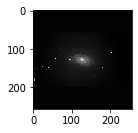

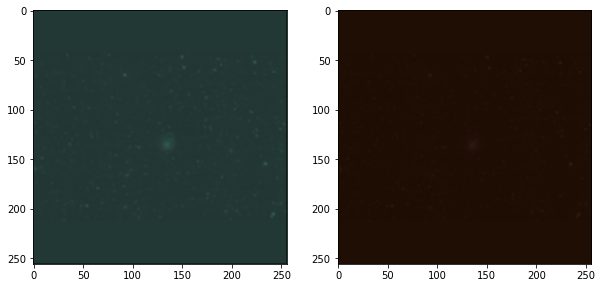

In [180]:
model.compile(optimizer='sgd',loss='MSE',metrics=['accuracy'])

model.fit(dataset_train,epochs=3, callbacks=[MyCustomCallback(dossier,model,dataset_val)], validation_data=dataset_val)
output = model.predict(a[0])
print(a[0].shape)
plt.figure(figsize=(10,15))
plt.subplot(1,2,1)
plt.imshow(output[2,:,:,:])
plt.subplot(1,2,2)
plt.imshow(a[0][2,:,:,:])

# Résultats premier groupe d'entrainement (avant erreur de dimension)

Results summary
|-Results in Bayesian_optimization/Modele000002_Keras_Bayesian
|-Showing 10 best trials
|-Objective(name='val_accuracy', direction='max')
Trial summary
|-Trial ID: e3de1ef4d6472fd0557549403c1a956e
|-Score: 0.846445620059967
|-Best step: 0
Hyperparameters:
|-activation_conv_index_0_etg_0_desc: relu
|-activation_conv_index_0_etg_0_remont: relu
|-activation_conv_index_0_etg_1_desc: linear
|-activation_conv_index_0_etg_1_remont: linear
|-activation_conv_index_0_etg_2_desc: selu
|-activation_conv_index_0_etg_2_remont: relu
|-activation_conv_index_0_etg_3_desc: linear
|-activation_conv_index_0_etg_3_remont: relu
|-activation_conv_index_0_etg_4_desc: elu
|-activation_conv_index_0_etg_4_remont: relu
|-activation_conv_index_0_etg_5_desc: relu
|-activation_conv_index_0_etg_5_remont: relu
|-activation_conv_index_0_etg_6_desc: relu
|-activation_conv_index_0_etg_6_remont: relu
|-activation_conv_index_0_etg_7_desc: relu
|-activation_conv_index_0_etg_7_remont: relu
|-activation_conv_index_0_etg_8_desc: relu
|-activation_conv_index_1_etg_0_desc: selu
|-activation_conv_index_1_etg_0_remont: relu
|-activation_conv_index_1_etg_1_desc: linear
|-activation_conv_index_1_etg_1_remont: relu
|-activation_conv_index_1_etg_2_desc: relu
|-activation_conv_index_1_etg_2_remont: elu
|-activation_conv_index_1_etg_3_desc: relu
|-activation_conv_index_1_etg_3_remont: relu
|-activation_conv_index_2_etg_0_desc: selu
|-activation_conv_index_2_etg_0_remont: elu
|-activation_conv_index_2_etg_1_desc: tanh
|-activation_conv_index_2_etg_2_desc: relu
|-activation_conv_index_2_etg_2_remont: tanh
|-activation_conv_index_2_etg_3_desc: relu
|-activation_conv_index_2_etg_3_remont: relu
|-activation_conv_index_3_etg_0_remont: selu
|-activation_conv_index_3_etg_2_desc: relu
|-beta_1: 1.1567454740840701
|-beta_2: 1.1580270355932856
|-filtre_conv_index_0_etg_0_desc: 100
|-filtre_conv_index_0_etg_0_remont: 100
|-filtre_conv_index_0_etg_1_desc: 1
|-filtre_conv_index_0_etg_1_remont: 100
|-filtre_conv_index_0_etg_2_desc: 10
|-filtre_conv_index_0_etg_2_remont: 3
|-filtre_conv_index_0_etg_3_desc: 3
|-filtre_conv_index_0_etg_3_remont: 50
|-filtre_conv_index_0_etg_4_desc: 500
|-filtre_conv_index_0_etg_4_remont: 1
|-filtre_conv_index_0_etg_5_desc: 1
|-filtre_conv_index_0_etg_5_remont: 1
|-filtre_conv_index_0_etg_6_desc: 1
|-filtre_conv_index_0_etg_6_remont: 1
|-filtre_conv_index_0_etg_7_desc: 1
|-filtre_conv_index_0_etg_7_remont: 1
|-filtre_conv_index_0_etg_8_desc: 1
|-filtre_conv_index_1_etg_0_desc: 50
|-filtre_conv_index_1_etg_0_remont: 50
|-filtre_conv_index_1_etg_1_desc: 500
|-filtre_conv_index_1_etg_1_remont: 1
|-filtre_conv_index_1_etg_2_desc: 1
|-filtre_conv_index_1_etg_2_remont: 50
|-filtre_conv_index_1_etg_3_desc: 1
|-filtre_conv_index_1_etg_3_remont: 1
|-filtre_conv_index_2_etg_0_desc: 500
|-filtre_conv_index_2_etg_0_remont: 50
|-filtre_conv_index_2_etg_1_desc: 10
|-filtre_conv_index_2_etg_2_desc: 1
|-filtre_conv_index_2_etg_2_remont: 100
|-filtre_conv_index_2_etg_3_desc: 1
|-filtre_conv_index_2_etg_3_remont: 1
|-filtre_conv_index_3_etg_0_remont: 3
|-filtre_conv_index_3_etg_2_desc: 1
|-filtre_deconv_etg_0_remont: 1
|-filtre_deconv_etg_1_remont: 3
|-filtre_deconv_etg_2_remont: 50
|-filtre_deconv_etg_3_remont: 50
|-filtre_deconv_etg_4_remont: 1
|-filtre_deconv_etg_5_remont: 1
|-filtre_deconv_etg_6_remont: 1
|-filtre_deconv_etg_7_remont: 1
|-kernel_conv_index_0_etg_0_desc: 3
|-kernel_conv_index_0_etg_0_remont: 2
|-kernel_conv_index_0_etg_1_desc: 3
|-kernel_conv_index_0_etg_1_remont: 3
|-kernel_conv_index_0_etg_2_desc: 3
|-kernel_conv_index_0_etg_2_remont: 2
|-kernel_conv_index_0_etg_3_desc: 2
|-kernel_conv_index_0_etg_3_remont: 2
|-kernel_conv_index_0_etg_4_desc: 3
|-kernel_conv_index_0_etg_4_remont: 2
|-kernel_conv_index_0_etg_5_desc: 2
|-kernel_conv_index_0_etg_5_remont: 2
|-kernel_conv_index_0_etg_6_desc: 2
|-kernel_conv_index_0_etg_6_remont: 2
|-kernel_conv_index_0_etg_7_desc: 2
|-kernel_conv_index_0_etg_7_remont: 2
|-kernel_conv_index_0_etg_8_desc: 2
|-kernel_conv_index_1_etg_0_desc: 3
|-kernel_conv_index_1_etg_0_remont: 3
|-kernel_conv_index_1_etg_1_desc: 2
|-kernel_conv_index_1_etg_1_remont: 2
|-kernel_conv_index_1_etg_2_desc: 2
|-kernel_conv_index_1_etg_2_remont: 2
|-kernel_conv_index_1_etg_3_desc: 2
|-kernel_conv_index_1_etg_3_remont: 2
|-kernel_conv_index_2_etg_0_desc: 3
|-kernel_conv_index_2_etg_0_remont: 3
|-kernel_conv_index_2_etg_1_desc: 2
|-kernel_conv_index_2_etg_2_desc: 2
|-kernel_conv_index_2_etg_2_remont: 3
|-kernel_conv_index_2_etg_3_desc: 2
|-kernel_conv_index_2_etg_3_remont: 2
|-kernel_conv_index_3_etg_0_remont: 2
|-kernel_conv_index_3_etg_2_desc: 2
|-learning_rate: 1e-05
|-nb_conv_etg_0_desc: 3
|-nb_conv_etg_0_remont: 4
|-nb_conv_etg_1_desc: 2
|-nb_conv_etg_1_remont: 2
|-nb_conv_etg_2_desc: 4
|-nb_conv_etg_2_remont: 2
|-nb_conv_etg_3_desc: 3
|-nb_conv_etg_3_remont: 3
|-nb_conv_etg_4_desc: 0
|-nb_conv_etg_4_remont: 1
|-nb_conv_etg_5_desc: 1
|-nb_conv_etg_5_remont: 1
|-nb_conv_etg_6_desc: 1
|-nb_conv_etg_6_remont: 1
|-nb_conv_etg_7_desc: 1
|-nb_conv_etg_7_remont: 1
|-nb_conv_etg_8_desc: 1
|-nb_pool: 8
|-pool_type_0: max
|-pool_type_1: max
|-pool_type_2: max
|-pool_type_3: max
|-pool_type_4: max
|-pool_type_5: max
|-pool_type_6: max
|-pool_type_7: max
Trial summary
|-Trial ID: f5fa2f79bdd80f70c674000201c6f0e0
|-Score: 0.846445620059967
|-Best step: 0
Hyperparameters:
|-activation_conv_index_0_etg_0_desc: tanh
|-activation_conv_index_0_etg_0_remont: selu
|-activation_conv_index_0_etg_1_desc: tanh
|-activation_conv_index_0_etg_1_remont: relu
|-activation_conv_index_0_etg_2_desc: tanh
|-activation_conv_index_0_etg_2_remont: elu
|-activation_conv_index_0_etg_3_desc: linear
|-activation_conv_index_0_etg_3_remont: selu
|-activation_conv_index_0_etg_4_desc: tanh
|-activation_conv_index_0_etg_4_remont: tanh
|-activation_conv_index_0_etg_5_desc: selu
|-activation_conv_index_0_etg_5_remont: elu
|-activation_conv_index_0_etg_6_desc: linear
|-activation_conv_index_0_etg_6_remont: linear
|-activation_conv_index_0_etg_7_desc: selu
|-activation_conv_index_0_etg_7_remont: tanh
|-activation_conv_index_0_etg_8_desc: relu
|-activation_conv_index_1_etg_0_desc: tanh
|-activation_conv_index_1_etg_0_remont: elu
|-activation_conv_index_1_etg_1_desc: tanh
|-activation_conv_index_1_etg_1_remont: selu
|-activation_conv_index_1_etg_2_desc: linear
|-activation_conv_index_1_etg_2_remont: elu
|-activation_conv_index_1_etg_3_desc: linear
|-activation_conv_index_1_etg_3_remont: elu
|-activation_conv_index_1_etg_4_desc: relu
|-activation_conv_index_1_etg_4_remont: relu
|-activation_conv_index_1_etg_5_remont: relu
|-activation_conv_index_1_etg_6_desc: relu
|-activation_conv_index_1_etg_7_desc: relu
|-activation_conv_index_1_etg_7_remont: relu
|-activation_conv_index_1_etg_8_desc: relu
|-activation_conv_index_2_etg_0_desc: relu
|-activation_conv_index_2_etg_0_remont: linear
|-activation_conv_index_2_etg_1_desc: selu
|-activation_conv_index_2_etg_2_desc: elu
|-activation_conv_index_2_etg_2_remont: selu
|-activation_conv_index_2_etg_3_desc: linear
|-activation_conv_index_2_etg_3_remont: relu
|-activation_conv_index_2_etg_4_desc: relu
|-activation_conv_index_2_etg_4_remont: relu
|-activation_conv_index_2_etg_7_desc: relu
|-activation_conv_index_2_etg_7_remont: relu
|-activation_conv_index_2_etg_8_desc: relu
|-activation_conv_index_3_etg_0_remont: elu
|-activation_conv_index_3_etg_2_desc: relu
|-activation_conv_index_3_etg_7_remont: relu
|-beta_1: 0.9672309653263195
|-beta_2: 1.0901985450142682
|-filtre_conv_index_0_etg_0_desc: 100
|-filtre_conv_index_0_etg_0_remont: 100
|-filtre_conv_index_0_etg_1_desc: 10
|-filtre_conv_index_0_etg_1_remont: 3
|-filtre_conv_index_0_etg_2_desc: 10
|-filtre_conv_index_0_etg_2_remont: 500
|-filtre_conv_index_0_etg_3_desc: 50
|-filtre_conv_index_0_etg_3_remont: 100
|-filtre_conv_index_0_etg_4_desc: 1
|-filtre_conv_index_0_etg_4_remont: 1
|-filtre_conv_index_0_etg_5_desc: 10
|-filtre_conv_index_0_etg_5_remont: 100
|-filtre_conv_index_0_etg_6_desc: 500
|-filtre_conv_index_0_etg_6_remont: 50
|-filtre_conv_index_0_etg_7_desc: 500
|-filtre_conv_index_0_etg_7_remont: 100
|-filtre_conv_index_0_etg_8_desc: 500
|-filtre_conv_index_1_etg_0_desc: 50
|-filtre_conv_index_1_etg_0_remont: 50
|-filtre_conv_index_1_etg_1_desc: 500
|-filtre_conv_index_1_etg_1_remont: 3
|-filtre_conv_index_1_etg_2_desc: 500
|-filtre_conv_index_1_etg_2_remont: 3
|-filtre_conv_index_1_etg_3_desc: 500
|-filtre_conv_index_1_etg_3_remont: 50
|-filtre_conv_index_1_etg_4_desc: 1
|-filtre_conv_index_1_etg_4_remont: 1
|-filtre_conv_index_1_etg_5_remont: 1
|-filtre_conv_index_1_etg_6_desc: 1
|-filtre_conv_index_1_etg_7_desc: 1
|-filtre_conv_index_1_etg_7_remont: 1
|-filtre_conv_index_1_etg_8_desc: 1
|-filtre_conv_index_2_etg_0_desc: 3
|-filtre_conv_index_2_etg_0_remont: 10
|-filtre_conv_index_2_etg_1_desc: 100
|-filtre_conv_index_2_etg_2_desc: 50
|-filtre_conv_index_2_etg_2_remont: 50
|-filtre_conv_index_2_etg_3_desc: 500
|-filtre_conv_index_2_etg_3_remont: 50
|-filtre_conv_index_2_etg_4_desc: 1
|-filtre_conv_index_2_etg_4_remont: 1
|-filtre_conv_index_2_etg_7_desc: 1
|-filtre_conv_index_2_etg_7_remont: 1
|-filtre_conv_index_2_etg_8_desc: 1
|-filtre_conv_index_3_etg_0_remont: 3
|-filtre_conv_index_3_etg_2_desc: 1
|-filtre_conv_index_3_etg_7_remont: 1
|-filtre_deconv_etg_0_remont: 1
|-filtre_deconv_etg_1_remont: 50
|-filtre_deconv_etg_2_remont: 500
|-filtre_deconv_etg_3_remont: 1
|-filtre_deconv_etg_4_remont: 3
|-filtre_deconv_etg_5_remont: 50
|-filtre_deconv_etg_6_remont: 10
|-filtre_deconv_etg_7_remont: 100
|-kernel_conv_index_0_etg_0_desc: 2
|-kernel_conv_index_0_etg_0_remont: 3
|-kernel_conv_index_0_etg_1_desc: 3
|-kernel_conv_index_0_etg_1_remont: 3
|-kernel_conv_index_0_etg_2_desc: 3
|-kernel_conv_index_0_etg_2_remont: 3
|-kernel_conv_index_0_etg_3_desc: 2
|-kernel_conv_index_0_etg_3_remont: 3
|-kernel_conv_index_0_etg_4_desc: 3
|-kernel_conv_index_0_etg_4_remont: 2
|-kernel_conv_index_0_etg_5_desc: 2
|-kernel_conv_index_0_etg_5_remont: 3
|-kernel_conv_index_0_etg_6_desc: 2
|-kernel_conv_index_0_etg_6_remont: 2
|-kernel_conv_index_0_etg_7_desc: 2
|-kernel_conv_index_0_etg_7_remont: 3
|-kernel_conv_index_0_etg_8_desc: 2
|-kernel_conv_index_1_etg_0_desc: 3
|-kernel_conv_index_1_etg_0_remont: 2
|-kernel_conv_index_1_etg_1_desc: 3
|-kernel_conv_index_1_etg_1_remont: 3
|-kernel_conv_index_1_etg_2_desc: 2
|-kernel_conv_index_1_etg_2_remont: 3
|-kernel_conv_index_1_etg_3_desc: 2
|-kernel_conv_index_1_etg_3_remont: 2
|-kernel_conv_index_1_etg_4_desc: 2
|-kernel_conv_index_1_etg_4_remont: 2
|-kernel_conv_index_1_etg_5_remont: 2
|-kernel_conv_index_1_etg_6_desc: 2
|-kernel_conv_index_1_etg_7_desc: 2
|-kernel_conv_index_1_etg_7_remont: 2
|-kernel_conv_index_1_etg_8_desc: 2
|-kernel_conv_index_2_etg_0_desc: 3
|-kernel_conv_index_2_etg_0_remont: 3
|-kernel_conv_index_2_etg_1_desc: 2
|-kernel_conv_index_2_etg_2_desc: 3
|-kernel_conv_index_2_etg_2_remont: 2
|-kernel_conv_index_2_etg_3_desc: 3
|-kernel_conv_index_2_etg_3_remont: 3
|-kernel_conv_index_2_etg_4_desc: 2
|-kernel_conv_index_2_etg_4_remont: 2
|-kernel_conv_index_2_etg_7_desc: 2
|-kernel_conv_index_2_etg_7_remont: 2
|-kernel_conv_index_2_etg_8_desc: 2
|-kernel_conv_index_3_etg_0_remont: 3
|-kernel_conv_index_3_etg_2_desc: 3
|-kernel_conv_index_3_etg_7_remont: 2
|-learning_rate: 1e-05
|-nb_conv_etg_0_desc: 3
|-nb_conv_etg_0_remont: 1
|-nb_conv_etg_1_desc: 1
|-nb_conv_etg_1_remont: 0
|-nb_conv_etg_2_desc: 2
|-nb_conv_etg_2_remont: 2
|-nb_conv_etg_3_desc: 1
|-nb_conv_etg_3_remont: 1
|-nb_conv_etg_4_desc: 3
|-nb_conv_etg_4_remont: 3
|-nb_conv_etg_5_desc: 1
|-nb_conv_etg_5_remont: 2
|-nb_conv_etg_6_desc: 2
|-nb_conv_etg_6_remont: 0
|-nb_conv_etg_7_desc: 3
|-nb_conv_etg_7_remont: 4
|-nb_conv_etg_8_desc: 3
|-nb_pool: 8
|-pool_type_0: avg
|-pool_type_1: avg
|-pool_type_2: max
|-pool_type_3: max
|-pool_type_4: avg
|-pool_type_5: avg
|-pool_type_6: avg
|-pool_type_7: avg
Trial summary
|-Trial ID: dd92e50cfa43158b2b257e19be3fa684
|-Score: 0.8454128305117289
|-Best step: 0
Hyperparameters:
|-activation_conv_index_0_etg_0_desc: tanh
|-activation_conv_index_0_etg_0_remont: selu
|-activation_conv_index_0_etg_1_desc: tanh
|-activation_conv_index_0_etg_1_remont: linear
|-activation_conv_index_0_etg_2_desc: linear
|-activation_conv_index_0_etg_2_remont: selu
|-activation_conv_index_0_etg_3_desc: tanh
|-activation_conv_index_0_etg_3_remont: elu
|-activation_conv_index_0_etg_4_desc: relu
|-activation_conv_index_0_etg_4_remont: selu
|-activation_conv_index_0_etg_5_desc: relu
|-activation_conv_index_0_etg_5_remont: relu
|-activation_conv_index_0_etg_6_desc: relu
|-activation_conv_index_0_etg_6_remont: relu
|-activation_conv_index_0_etg_7_desc: relu
|-activation_conv_index_0_etg_7_remont: selu
|-activation_conv_index_0_etg_8_desc: relu
|-activation_conv_index_1_etg_0_desc: tanh
|-activation_conv_index_1_etg_0_remont: tanh
|-activation_conv_index_1_etg_1_desc: elu
|-activation_conv_index_1_etg_1_remont: selu
|-activation_conv_index_1_etg_2_desc: selu
|-activation_conv_index_1_etg_2_remont: selu
|-activation_conv_index_1_etg_3_desc: linear
|-activation_conv_index_1_etg_3_remont: tanh
|-activation_conv_index_1_etg_4_desc: selu
|-activation_conv_index_1_etg_4_remont: linear
|-activation_conv_index_1_etg_5_desc: linear
|-activation_conv_index_1_etg_5_remont: selu
|-activation_conv_index_1_etg_6_desc: relu
|-activation_conv_index_1_etg_6_remont: linear
|-activation_conv_index_1_etg_7_desc: linear
|-activation_conv_index_1_etg_7_remont: relu
|-activation_conv_index_1_etg_8_desc: elu
|-activation_conv_index_2_etg_0_desc: linear
|-activation_conv_index_2_etg_0_remont: linear
|-activation_conv_index_2_etg_1_desc: selu
|-activation_conv_index_2_etg_1_remont: relu
|-activation_conv_index_2_etg_2_desc: tanh
|-activation_conv_index_2_etg_2_remont: linear
|-activation_conv_index_2_etg_3_desc: linear
|-activation_conv_index_2_etg_3_remont: relu
|-activation_conv_index_2_etg_4_desc: selu
|-activation_conv_index_2_etg_4_remont: selu
|-activation_conv_index_2_etg_5_remont: selu
|-activation_conv_index_2_etg_7_desc: linear
|-activation_conv_index_2_etg_7_remont: elu
|-activation_conv_index_2_etg_8_desc: relu
|-activation_conv_index_3_etg_0_desc: relu
|-activation_conv_index_3_etg_0_remont: elu
|-activation_conv_index_3_etg_1_desc: relu
|-activation_conv_index_3_etg_1_remont: selu
|-activation_conv_index_3_etg_2_desc: relu
|-activation_conv_index_3_etg_4_desc: selu
|-activation_conv_index_3_etg_7_remont: elu
|-beta_1: 0.9237723724948255
|-beta_2: 0.8373641141314946
|-filtre_conv_index_0_etg_0_desc: 10
|-filtre_conv_index_0_etg_0_remont: 1
|-filtre_conv_index_0_etg_1_desc: 500
|-filtre_conv_index_0_etg_1_remont: 50
|-filtre_conv_index_0_etg_2_desc: 1
|-filtre_conv_index_0_etg_2_remont: 3
|-filtre_conv_index_0_etg_3_desc: 500
|-filtre_conv_index_0_etg_3_remont: 100
|-filtre_conv_index_0_etg_4_desc: 100
|-filtre_conv_index_0_etg_4_remont: 1
|-filtre_conv_index_0_etg_5_desc: 1
|-filtre_conv_index_0_etg_5_remont: 50
|-filtre_conv_index_0_etg_6_desc: 100
|-filtre_conv_index_0_etg_6_remont: 1
|-filtre_conv_index_0_etg_7_desc: 50
|-filtre_conv_index_0_etg_7_remont: 500
|-filtre_conv_index_0_etg_8_desc: 100
|-filtre_conv_index_1_etg_0_desc: 3
|-filtre_conv_index_1_etg_0_remont: 100
|-filtre_conv_index_1_etg_1_desc: 50
|-filtre_conv_index_1_etg_1_remont: 50
|-filtre_conv_index_1_etg_2_desc: 10
|-filtre_conv_index_1_etg_2_remont: 1
|-filtre_conv_index_1_etg_3_desc: 10
|-filtre_conv_index_1_etg_3_remont: 10
|-filtre_conv_index_1_etg_4_desc: 500
|-filtre_conv_index_1_etg_4_remont: 500
|-filtre_conv_index_1_etg_5_desc: 500
|-filtre_conv_index_1_etg_5_remont: 1
|-filtre_conv_index_1_etg_6_desc: 100
|-filtre_conv_index_1_etg_6_remont: 50
|-filtre_conv_index_1_etg_7_desc: 50
|-filtre_conv_index_1_etg_7_remont: 3
|-filtre_conv_index_1_etg_8_desc: 50
|-filtre_conv_index_2_etg_0_desc: 50
|-filtre_conv_index_2_etg_0_remont: 3
|-filtre_conv_index_2_etg_1_desc: 10
|-filtre_conv_index_2_etg_1_remont: 100
|-filtre_conv_index_2_etg_2_desc: 50
|-filtre_conv_index_2_etg_2_remont: 100
|-filtre_conv_index_2_etg_3_desc: 500
|-filtre_conv_index_2_etg_3_remont: 1
|-filtre_conv_index_2_etg_4_desc: 100
|-filtre_conv_index_2_etg_4_remont: 100
|-filtre_conv_index_2_etg_5_remont: 10
|-filtre_conv_index_2_etg_7_desc: 3
|-filtre_conv_index_2_etg_7_remont: 500
|-filtre_conv_index_2_etg_8_desc: 10
|-filtre_conv_index_3_etg_0_desc: 50
|-filtre_conv_index_3_etg_0_remont: 50
|-filtre_conv_index_3_etg_1_desc: 50
|-filtre_conv_index_3_etg_1_remont: 100
|-filtre_conv_index_3_etg_2_desc: 10
|-filtre_conv_index_3_etg_4_desc: 10
|-filtre_conv_index_3_etg_7_remont: 1
|-filtre_deconv_etg_0_remont: 500
|-filtre_deconv_etg_1_remont: 10
|-filtre_deconv_etg_2_remont: 500
|-filtre_deconv_etg_3_remont: 100
|-filtre_deconv_etg_4_remont: 500
|-filtre_deconv_etg_5_remont: 50
|-filtre_deconv_etg_6_remont: 3
|-filtre_deconv_etg_7_remont: 1
|-kernel_conv_index_0_etg_0_desc: 2
|-kernel_conv_index_0_etg_0_remont: 3
|-kernel_conv_index_0_etg_1_desc: 2
|-kernel_conv_index_0_etg_1_remont: 2
|-kernel_conv_index_0_etg_2_desc: 2
|-kernel_conv_index_0_etg_2_remont: 3
|-kernel_conv_index_0_etg_3_desc: 3
|-kernel_conv_index_0_etg_3_remont: 2
|-kernel_conv_index_0_etg_4_desc: 3
|-kernel_conv_index_0_etg_4_remont: 2
|-kernel_conv_index_0_etg_5_desc: 3
|-kernel_conv_index_0_etg_5_remont: 3
|-kernel_conv_index_0_etg_6_desc: 3
|-kernel_conv_index_0_etg_6_remont: 3
|-kernel_conv_index_0_etg_7_desc: 3
|-kernel_conv_index_0_etg_7_remont: 3
|-kernel_conv_index_0_etg_8_desc: 3
|-kernel_conv_index_1_etg_0_desc: 2
|-kernel_conv_index_1_etg_0_remont: 3
|-kernel_conv_index_1_etg_1_desc: 3
|-kernel_conv_index_1_etg_1_remont: 3
|-kernel_conv_index_1_etg_2_desc: 3
|-kernel_conv_index_1_etg_2_remont: 3
|-kernel_conv_index_1_etg_3_desc: 2
|-kernel_conv_index_1_etg_3_remont: 3
|-kernel_conv_index_1_etg_4_desc: 3
|-kernel_conv_index_1_etg_4_remont: 3
|-kernel_conv_index_1_etg_5_desc: 3
|-kernel_conv_index_1_etg_5_remont: 2
|-kernel_conv_index_1_etg_6_desc: 3
|-kernel_conv_index_1_etg_6_remont: 2
|-kernel_conv_index_1_etg_7_desc: 2
|-kernel_conv_index_1_etg_7_remont: 2
|-kernel_conv_index_1_etg_8_desc: 3
|-kernel_conv_index_2_etg_0_desc: 3
|-kernel_conv_index_2_etg_0_remont: 3
|-kernel_conv_index_2_etg_1_desc: 3
|-kernel_conv_index_2_etg_1_remont: 2
|-kernel_conv_index_2_etg_2_desc: 3
|-kernel_conv_index_2_etg_2_remont: 3
|-kernel_conv_index_2_etg_3_desc: 2
|-kernel_conv_index_2_etg_3_remont: 3
|-kernel_conv_index_2_etg_4_desc: 3
|-kernel_conv_index_2_etg_4_remont: 3
|-kernel_conv_index_2_etg_5_remont: 3
|-kernel_conv_index_2_etg_7_desc: 2
|-kernel_conv_index_2_etg_7_remont: 2
|-kernel_conv_index_2_etg_8_desc: 2
|-kernel_conv_index_3_etg_0_desc: 2
|-kernel_conv_index_3_etg_0_remont: 2
|-kernel_conv_index_3_etg_1_desc: 2
|-kernel_conv_index_3_etg_1_remont: 3
|-kernel_conv_index_3_etg_2_desc: 2
|-kernel_conv_index_3_etg_4_desc: 3
|-kernel_conv_index_3_etg_7_remont: 2
|-learning_rate: 0.001
|-nb_conv_etg_0_desc: 1
|-nb_conv_etg_0_remont: 4
|-nb_conv_etg_1_desc: 1
|-nb_conv_etg_1_remont: 2
|-nb_conv_etg_2_desc: 1
|-nb_conv_etg_2_remont: 2
|-nb_conv_etg_3_desc: 0
|-nb_conv_etg_3_remont: 3
|-nb_conv_etg_4_desc: 2
|-nb_conv_etg_4_remont: 0
|-nb_conv_etg_5_desc: 3
|-nb_conv_etg_5_remont: 2
|-nb_conv_etg_6_desc: 3
|-nb_conv_etg_6_remont: 3
|-nb_conv_etg_7_desc: 1
|-nb_conv_etg_7_remont: 0
|-nb_conv_etg_8_desc: 2
|-nb_pool: 2
|-pool_type_0: max
|-pool_type_1: max
|-pool_type_2: max
|-pool_type_3: avg
|-pool_type_4: max
|-pool_type_5: avg
|-pool_type_6: max
|-pool_type_7: max
Trial summary
|-Trial ID: 5816df68396ef8e46cacd3f962aadd2d
|-Score: 0.5878276079893112
|-Best step: 0
Hyperparameters:
|-activation_conv_index_0_etg_0_desc: elu
|-activation_conv_index_0_etg_0_remont: tanh
|-activation_conv_index_0_etg_1_desc: elu
|-activation_conv_index_0_etg_1_remont: tanh
|-activation_conv_index_0_etg_2_desc: tanh
|-activation_conv_index_0_etg_2_remont: linear
|-activation_conv_index_0_etg_3_desc: selu
|-activation_conv_index_0_etg_3_remont: elu
|-activation_conv_index_0_etg_4_desc: elu
|-activation_conv_index_0_etg_4_remont: relu
|-activation_conv_index_0_etg_5_desc: tanh
|-activation_conv_index_0_etg_5_remont: relu
|-activation_conv_index_0_etg_6_desc: relu
|-activation_conv_index_0_etg_6_remont: tanh
|-activation_conv_index_0_etg_7_desc: tanh
|-activation_conv_index_0_etg_7_remont: selu
|-activation_conv_index_0_etg_8_desc: relu
|-activation_conv_index_1_etg_0_desc: linear
|-activation_conv_index_1_etg_0_remont: linear
|-activation_conv_index_1_etg_1_desc: selu
|-activation_conv_index_1_etg_1_remont: tanh
|-activation_conv_index_1_etg_2_desc: tanh
|-activation_conv_index_1_etg_2_remont: relu
|-activation_conv_index_1_etg_3_desc: tanh
|-activation_conv_index_1_etg_3_remont: relu
|-activation_conv_index_1_etg_4_desc: relu
|-activation_conv_index_1_etg_4_remont: tanh
|-activation_conv_index_1_etg_5_remont: tanh
|-activation_conv_index_1_etg_6_desc: elu
|-activation_conv_index_1_etg_7_desc: selu
|-activation_conv_index_1_etg_7_remont: relu
|-activation_conv_index_1_etg_8_desc: relu
|-activation_conv_index_2_etg_0_desc: tanh
|-activation_conv_index_2_etg_0_remont: elu
|-activation_conv_index_2_etg_1_desc: elu
|-activation_conv_index_2_etg_2_desc: linear
|-activation_conv_index_2_etg_2_remont: tanh
|-activation_conv_index_2_etg_3_desc: relu
|-activation_conv_index_2_etg_3_remont: selu
|-activation_conv_index_2_etg_4_desc: linear
|-activation_conv_index_2_etg_4_remont: tanh
|-activation_conv_index_2_etg_7_desc: elu
|-activation_conv_index_2_etg_7_remont: elu
|-activation_conv_index_2_etg_8_desc: tanh
|-activation_conv_index_3_etg_0_remont: linear
|-activation_conv_index_3_etg_2_desc: relu
|-activation_conv_index_3_etg_7_remont: tanh
|-beta_1: 0.9765124137619023
|-beta_2: 0.8646209488191324
|-filtre_conv_index_0_etg_0_desc: 100
|-filtre_conv_index_0_etg_0_remont: 10
|-filtre_conv_index_0_etg_1_desc: 1
|-filtre_conv_index_0_etg_1_remont: 500
|-filtre_conv_index_0_etg_2_desc: 3
|-filtre_conv_index_0_etg_2_remont: 500
|-filtre_conv_index_0_etg_3_desc: 500
|-filtre_conv_index_0_etg_3_remont: 50
|-filtre_conv_index_0_etg_4_desc: 10
|-filtre_conv_index_0_etg_4_remont: 50
|-filtre_conv_index_0_etg_5_desc: 10
|-filtre_conv_index_0_etg_5_remont: 1
|-filtre_conv_index_0_etg_6_desc: 500
|-filtre_conv_index_0_etg_6_remont: 100
|-filtre_conv_index_0_etg_7_desc: 10
|-filtre_conv_index_0_etg_7_remont: 1
|-filtre_conv_index_0_etg_8_desc: 1
|-filtre_conv_index_1_etg_0_desc: 3
|-filtre_conv_index_1_etg_0_remont: 50
|-filtre_conv_index_1_etg_1_desc: 500
|-filtre_conv_index_1_etg_1_remont: 500
|-filtre_conv_index_1_etg_2_desc: 500
|-filtre_conv_index_1_etg_2_remont: 100
|-filtre_conv_index_1_etg_3_desc: 10
|-filtre_conv_index_1_etg_3_remont: 500
|-filtre_conv_index_1_etg_4_desc: 500
|-filtre_conv_index_1_etg_4_remont: 500
|-filtre_conv_index_1_etg_5_remont: 10
|-filtre_conv_index_1_etg_6_desc: 10
|-filtre_conv_index_1_etg_7_desc: 1
|-filtre_conv_index_1_etg_7_remont: 10
|-filtre_conv_index_1_etg_8_desc: 10
|-filtre_conv_index_2_etg_0_desc: 500
|-filtre_conv_index_2_etg_0_remont: 100
|-filtre_conv_index_2_etg_1_desc: 500
|-filtre_conv_index_2_etg_2_desc: 500
|-filtre_conv_index_2_etg_2_remont: 500
|-filtre_conv_index_2_etg_3_desc: 10
|-filtre_conv_index_2_etg_3_remont: 10
|-filtre_conv_index_2_etg_4_desc: 50
|-filtre_conv_index_2_etg_4_remont: 50
|-filtre_conv_index_2_etg_7_desc: 100
|-filtre_conv_index_2_etg_7_remont: 100
|-filtre_conv_index_2_etg_8_desc: 3
|-filtre_conv_index_3_etg_0_remont: 3
|-filtre_conv_index_3_etg_2_desc: 10
|-filtre_conv_index_3_etg_7_remont: 3
|-filtre_deconv_etg_0_remont: 3
|-filtre_deconv_etg_1_remont: 50
|-filtre_deconv_etg_2_remont: 10
|-filtre_deconv_etg_3_remont: 1
|-filtre_deconv_etg_4_remont: 500
|-filtre_deconv_etg_5_remont: 3
|-filtre_deconv_etg_6_remont: 500
|-filtre_deconv_etg_7_remont: 100
|-kernel_conv_index_0_etg_0_desc: 3
|-kernel_conv_index_0_etg_0_remont: 2
|-kernel_conv_index_0_etg_1_desc: 2
|-kernel_conv_index_0_etg_1_remont: 2
|-kernel_conv_index_0_etg_2_desc: 2
|-kernel_conv_index_0_etg_2_remont: 3
|-kernel_conv_index_0_etg_3_desc: 3
|-kernel_conv_index_0_etg_3_remont: 3
|-kernel_conv_index_0_etg_4_desc: 2
|-kernel_conv_index_0_etg_4_remont: 3
|-kernel_conv_index_0_etg_5_desc: 3
|-kernel_conv_index_0_etg_5_remont: 3
|-kernel_conv_index_0_etg_6_desc: 3
|-kernel_conv_index_0_etg_6_remont: 2
|-kernel_conv_index_0_etg_7_desc: 3
|-kernel_conv_index_0_etg_7_remont: 3
|-kernel_conv_index_0_etg_8_desc: 2
|-kernel_conv_index_1_etg_0_desc: 2
|-kernel_conv_index_1_etg_0_remont: 3
|-kernel_conv_index_1_etg_1_desc: 3
|-kernel_conv_index_1_etg_1_remont: 3
|-kernel_conv_index_1_etg_2_desc: 3
|-kernel_conv_index_1_etg_2_remont: 3
|-kernel_conv_index_1_etg_3_desc: 3
|-kernel_conv_index_1_etg_3_remont: 2
|-kernel_conv_index_1_etg_4_desc: 2
|-kernel_conv_index_1_etg_4_remont: 2
|-kernel_conv_index_1_etg_5_remont: 3
|-kernel_conv_index_1_etg_6_desc: 3
|-kernel_conv_index_1_etg_7_desc: 2
|-kernel_conv_index_1_etg_7_remont: 2
|-kernel_conv_index_1_etg_8_desc: 2
|-kernel_conv_index_2_etg_0_desc: 3
|-kernel_conv_index_2_etg_0_remont: 3
|-kernel_conv_index_2_etg_1_desc: 3
|-kernel_conv_index_2_etg_2_desc: 2
|-kernel_conv_index_2_etg_2_remont: 2
|-kernel_conv_index_2_etg_3_desc: 3
|-kernel_conv_index_2_etg_3_remont: 3
|-kernel_conv_index_2_etg_4_desc: 3
|-kernel_conv_index_2_etg_4_remont: 2
|-kernel_conv_index_2_etg_7_desc: 3
|-kernel_conv_index_2_etg_7_remont: 2
|-kernel_conv_index_2_etg_8_desc: 3
|-kernel_conv_index_3_etg_0_remont: 2
|-kernel_conv_index_3_etg_2_desc: 2
|-kernel_conv_index_3_etg_7_remont: 2
|-learning_rate: 0.001
|-nb_conv_etg_0_desc: 1
|-nb_conv_etg_0_remont: 3
|-nb_conv_etg_1_desc: 2
|-nb_conv_etg_1_remont: 2
|-nb_conv_etg_2_desc: 4
|-nb_conv_etg_2_remont: 1
|-nb_conv_etg_3_desc: 1
|-nb_conv_etg_3_remont: 1
|-nb_conv_etg_4_desc: 2
|-nb_conv_etg_4_remont: 2
|-nb_conv_etg_5_desc: 0
|-nb_conv_etg_5_remont: 2
|-nb_conv_etg_6_desc: 4
|-nb_conv_etg_6_remont: 1
|-nb_conv_etg_7_desc: 1
|-nb_conv_etg_7_remont: 0
|-nb_conv_etg_8_desc: 4
|-nb_pool: 0
|-pool_type_0: avg
|-pool_type_1: avg
|-pool_type_2: max
|-pool_type_3: avg
|-pool_type_4: max
|-pool_type_5: avg
|-pool_type_6: max
|-pool_type_7: avg
Trial summary
|-Trial ID: 2eef72f23e24f4a83aa8023a3b3121eb
|-Score: 0.5867435956994692
|-Best step: 0
Hyperparameters:
|-activation_conv_index_0_etg_0_desc: elu
|-activation_conv_index_0_etg_0_remont: relu
|-activation_conv_index_0_etg_1_desc: selu
|-activation_conv_index_0_etg_1_remont: selu
|-activation_conv_index_0_etg_2_desc: tanh
|-activation_conv_index_0_etg_2_remont: tanh
|-activation_conv_index_0_etg_3_desc: tanh
|-activation_conv_index_0_etg_3_remont: relu
|-activation_conv_index_0_etg_4_desc: linear
|-activation_conv_index_1_etg_0_desc: selu
|-activation_conv_index_1_etg_0_remont: relu
|-activation_conv_index_1_etg_1_desc: relu
|-activation_conv_index_1_etg_2_remont: relu
|-activation_conv_index_2_etg_0_desc: linear
|-activation_conv_index_2_etg_0_remont: relu
|-activation_conv_index_2_etg_1_desc: relu
|-activation_conv_index_2_etg_2_remont: relu
|-activation_conv_index_3_etg_0_remont: relu
|-beta_1: 1.064355438665868
|-beta_2: 0.8195811574388034
|-filtre_conv_index_0_etg_0_desc: 1
|-filtre_conv_index_0_etg_0_remont: 10
|-filtre_conv_index_0_etg_1_desc: 3
|-filtre_conv_index_0_etg_1_remont: 10
|-filtre_conv_index_0_etg_2_desc: 10
|-filtre_conv_index_0_etg_2_remont: 500
|-filtre_conv_index_0_etg_3_desc: 500
|-filtre_conv_index_0_etg_3_remont: 3
|-filtre_conv_index_0_etg_4_desc: 500
|-filtre_conv_index_1_etg_0_desc: 50
|-filtre_conv_index_1_etg_0_remont: 1
|-filtre_conv_index_1_etg_1_desc: 1
|-filtre_conv_index_1_etg_2_remont: 1
|-filtre_conv_index_2_etg_0_desc: 3
|-filtre_conv_index_2_etg_0_remont: 1
|-filtre_conv_index_2_etg_1_desc: 1
|-filtre_conv_index_2_etg_2_remont: 1
|-filtre_conv_index_3_etg_0_remont: 1
|-filtre_deconv_etg_0_remont: 10
|-filtre_deconv_etg_1_remont: 100
|-filtre_deconv_etg_2_remont: 1
|-filtre_deconv_etg_3_remont: 1
|-kernel_conv_index_0_etg_0_desc: 3
|-kernel_conv_index_0_etg_0_remont: 2
|-kernel_conv_index_0_etg_1_desc: 2
|-kernel_conv_index_0_etg_1_remont: 3
|-kernel_conv_index_0_etg_2_desc: 3
|-kernel_conv_index_0_etg_2_remont: 3
|-kernel_conv_index_0_etg_3_desc: 3
|-kernel_conv_index_0_etg_3_remont: 3
|-kernel_conv_index_0_etg_4_desc: 2
|-kernel_conv_index_1_etg_0_desc: 2
|-kernel_conv_index_1_etg_0_remont: 2
|-kernel_conv_index_1_etg_1_desc: 2
|-kernel_conv_index_1_etg_2_remont: 2
|-kernel_conv_index_2_etg_0_desc: 2
|-kernel_conv_index_2_etg_0_remont: 2
|-kernel_conv_index_2_etg_1_desc: 2
|-kernel_conv_index_2_etg_2_remont: 2
|-kernel_conv_index_3_etg_0_remont: 2
|-learning_rate: 1e-05
|-nb_conv_etg_0_desc: 1
|-nb_conv_etg_0_remont: 4
|-nb_conv_etg_1_desc: 3
|-nb_conv_etg_1_remont: 1
|-nb_conv_etg_2_desc: 0
|-nb_conv_etg_2_remont: 3
|-nb_conv_etg_3_desc: 1
|-nb_conv_etg_3_remont: 1
|-nb_conv_etg_4_desc: 2
|-nb_pool: 3
|-pool_type_0: max
|-pool_type_1: avg
|-pool_type_2: avg
|-pool_type_3: avg
Trial summary
|-Trial ID: 9aea87148abf20fdbb03daf7564eb9a7
|-Score: 0.34692077338695526
|-Best step: 0
Hyperparameters:
|-activation_conv_index_0_etg_0_desc: elu
|-activation_conv_index_0_etg_0_remont: tanh
|-activation_conv_index_0_etg_1_desc: tanh
|-activation_conv_index_0_etg_1_remont: tanh
|-activation_conv_index_0_etg_2_desc: relu
|-activation_conv_index_0_etg_2_remont: linear
|-activation_conv_index_0_etg_3_desc: tanh
|-activation_conv_index_0_etg_3_remont: tanh
|-activation_conv_index_0_etg_4_desc: tanh
|-activation_conv_index_0_etg_4_remont: selu
|-activation_conv_index_0_etg_5_desc: elu
|-activation_conv_index_0_etg_5_remont: elu
|-activation_conv_index_0_etg_6_desc: relu
|-activation_conv_index_0_etg_6_remont: tanh
|-activation_conv_index_0_etg_7_desc: elu
|-activation_conv_index_0_etg_7_remont: relu
|-activation_conv_index_0_etg_8_desc: relu
|-activation_conv_index_1_etg_0_desc: relu
|-activation_conv_index_1_etg_0_remont: tanh
|-activation_conv_index_1_etg_1_desc: elu
|-activation_conv_index_1_etg_1_remont: selu
|-activation_conv_index_1_etg_2_desc: selu
|-activation_conv_index_1_etg_2_remont: linear
|-activation_conv_index_1_etg_3_desc: relu
|-activation_conv_index_1_etg_3_remont: elu
|-activation_conv_index_1_etg_4_desc: relu
|-activation_conv_index_1_etg_4_remont: relu
|-activation_conv_index_1_etg_5_desc: selu
|-activation_conv_index_1_etg_5_remont: relu
|-activation_conv_index_1_etg_6_desc: relu
|-activation_conv_index_1_etg_6_remont: elu
|-activation_conv_index_1_etg_7_desc: selu
|-activation_conv_index_1_etg_7_remont: tanh
|-activation_conv_index_1_etg_8_desc: relu
|-activation_conv_index_2_etg_0_desc: tanh
|-activation_conv_index_2_etg_0_remont: relu
|-activation_conv_index_2_etg_1_desc: relu
|-activation_conv_index_2_etg_1_remont: tanh
|-activation_conv_index_2_etg_2_desc: linear
|-activation_conv_index_2_etg_2_remont: tanh
|-activation_conv_index_2_etg_3_desc: linear
|-activation_conv_index_2_etg_3_remont: tanh
|-activation_conv_index_2_etg_4_desc: relu
|-activation_conv_index_2_etg_4_remont: tanh
|-activation_conv_index_2_etg_5_remont: linear
|-activation_conv_index_2_etg_7_desc: linear
|-activation_conv_index_2_etg_7_remont: selu
|-activation_conv_index_2_etg_8_desc: linear
|-activation_conv_index_3_etg_0_desc: relu
|-activation_conv_index_3_etg_0_remont: selu
|-activation_conv_index_3_etg_1_desc: selu
|-activation_conv_index_3_etg_1_remont: tanh
|-activation_conv_index_3_etg_2_desc: selu
|-activation_conv_index_3_etg_4_desc: selu
|-activation_conv_index_3_etg_7_remont: tanh
|-beta_1: 0.9185960187359232
|-beta_2: 0.9542589124228112
|-filtre_conv_index_0_etg_0_desc: 500
|-filtre_conv_index_0_etg_0_remont: 10
|-filtre_conv_index_0_etg_1_desc: 10
|-filtre_conv_index_0_etg_1_remont: 3
|-filtre_conv_index_0_etg_2_desc: 1
|-filtre_conv_index_0_etg_2_remont: 500
|-filtre_conv_index_0_etg_3_desc: 100
|-filtre_conv_index_0_etg_3_remont: 50
|-filtre_conv_index_0_etg_4_desc: 500
|-filtre_conv_index_0_etg_4_remont: 10
|-filtre_conv_index_0_etg_5_desc: 10
|-filtre_conv_index_0_etg_5_remont: 1
|-filtre_conv_index_0_etg_6_desc: 500
|-filtre_conv_index_0_etg_6_remont: 10
|-filtre_conv_index_0_etg_7_desc: 3
|-filtre_conv_index_0_etg_7_remont: 100
|-filtre_conv_index_0_etg_8_desc: 100
|-filtre_conv_index_1_etg_0_desc: 1
|-filtre_conv_index_1_etg_0_remont: 10
|-filtre_conv_index_1_etg_1_desc: 50
|-filtre_conv_index_1_etg_1_remont: 500
|-filtre_conv_index_1_etg_2_desc: 500
|-filtre_conv_index_1_etg_2_remont: 100
|-filtre_conv_index_1_etg_3_desc: 10
|-filtre_conv_index_1_etg_3_remont: 500
|-filtre_conv_index_1_etg_4_desc: 500
|-filtre_conv_index_1_etg_4_remont: 500
|-filtre_conv_index_1_etg_5_desc: 100
|-filtre_conv_index_1_etg_5_remont: 100
|-filtre_conv_index_1_etg_6_desc: 100
|-filtre_conv_index_1_etg_6_remont: 1
|-filtre_conv_index_1_etg_7_desc: 1
|-filtre_conv_index_1_etg_7_remont: 100
|-filtre_conv_index_1_etg_8_desc: 1
|-filtre_conv_index_2_etg_0_desc: 50
|-filtre_conv_index_2_etg_0_remont: 50
|-filtre_conv_index_2_etg_1_desc: 50
|-filtre_conv_index_2_etg_1_remont: 500
|-filtre_conv_index_2_etg_2_desc: 500
|-filtre_conv_index_2_etg_2_remont: 50
|-filtre_conv_index_2_etg_3_desc: 100
|-filtre_conv_index_2_etg_3_remont: 500
|-filtre_conv_index_2_etg_4_desc: 100
|-filtre_conv_index_2_etg_4_remont: 3
|-filtre_conv_index_2_etg_5_remont: 500
|-filtre_conv_index_2_etg_7_desc: 100
|-filtre_conv_index_2_etg_7_remont: 50
|-filtre_conv_index_2_etg_8_desc: 500
|-filtre_conv_index_3_etg_0_desc: 1
|-filtre_conv_index_3_etg_0_remont: 3
|-filtre_conv_index_3_etg_1_desc: 50
|-filtre_conv_index_3_etg_1_remont: 10
|-filtre_conv_index_3_etg_2_desc: 3
|-filtre_conv_index_3_etg_4_desc: 10
|-filtre_conv_index_3_etg_7_remont: 500
|-filtre_deconv_etg_0_remont: 1
|-filtre_deconv_etg_1_remont: 10
|-filtre_deconv_etg_2_remont: 10
|-filtre_deconv_etg_3_remont: 50
|-filtre_deconv_etg_4_remont: 1
|-filtre_deconv_etg_5_remont: 1
|-filtre_deconv_etg_6_remont: 1
|-filtre_deconv_etg_7_remont: 100
|-kernel_conv_index_0_etg_0_desc: 2
|-kernel_conv_index_0_etg_0_remont: 2
|-kernel_conv_index_0_etg_1_desc: 2
|-kernel_conv_index_0_etg_1_remont: 2
|-kernel_conv_index_0_etg_2_desc: 2
|-kernel_conv_index_0_etg_2_remont: 2
|-kernel_conv_index_0_etg_3_desc: 2
|-kernel_conv_index_0_etg_3_remont: 2
|-kernel_conv_index_0_etg_4_desc: 3
|-kernel_conv_index_0_etg_4_remont: 2
|-kernel_conv_index_0_etg_5_desc: 3
|-kernel_conv_index_0_etg_5_remont: 2
|-kernel_conv_index_0_etg_6_desc: 2
|-kernel_conv_index_0_etg_6_remont: 2
|-kernel_conv_index_0_etg_7_desc: 2
|-kernel_conv_index_0_etg_7_remont: 3
|-kernel_conv_index_0_etg_8_desc: 2
|-kernel_conv_index_1_etg_0_desc: 3
|-kernel_conv_index_1_etg_0_remont: 3
|-kernel_conv_index_1_etg_1_desc: 3
|-kernel_conv_index_1_etg_1_remont: 3
|-kernel_conv_index_1_etg_2_desc: 2
|-kernel_conv_index_1_etg_2_remont: 2
|-kernel_conv_index_1_etg_3_desc: 2
|-kernel_conv_index_1_etg_3_remont: 2
|-kernel_conv_index_1_etg_4_desc: 3
|-kernel_conv_index_1_etg_4_remont: 2
|-kernel_conv_index_1_etg_5_desc: 3
|-kernel_conv_index_1_etg_5_remont: 3
|-kernel_conv_index_1_etg_6_desc: 3
|-kernel_conv_index_1_etg_6_remont: 3
|-kernel_conv_index_1_etg_7_desc: 2
|-kernel_conv_index_1_etg_7_remont: 2
|-kernel_conv_index_1_etg_8_desc: 2
|-kernel_conv_index_2_etg_0_desc: 2
|-kernel_conv_index_2_etg_0_remont: 2
|-kernel_conv_index_2_etg_1_desc: 3
|-kernel_conv_index_2_etg_1_remont: 3
|-kernel_conv_index_2_etg_2_desc: 3
|-kernel_conv_index_2_etg_2_remont: 2
|-kernel_conv_index_2_etg_3_desc: 3
|-kernel_conv_index_2_etg_3_remont: 3
|-kernel_conv_index_2_etg_4_desc: 2
|-kernel_conv_index_2_etg_4_remont: 2
|-kernel_conv_index_2_etg_5_remont: 2
|-kernel_conv_index_2_etg_7_desc: 2
|-kernel_conv_index_2_etg_7_remont: 3
|-kernel_conv_index_2_etg_8_desc: 2
|-kernel_conv_index_3_etg_0_desc: 2
|-kernel_conv_index_3_etg_0_remont: 2
|-kernel_conv_index_3_etg_1_desc: 2
|-kernel_conv_index_3_etg_1_remont: 3
|-kernel_conv_index_3_etg_2_desc: 3
|-kernel_conv_index_3_etg_4_desc: 3
|-kernel_conv_index_3_etg_7_remont: 2
|-learning_rate: 1e-05
|-nb_conv_etg_0_desc: 4
|-nb_conv_etg_0_remont: 1
|-nb_conv_etg_1_desc: 3
|-nb_conv_etg_1_remont: 3
|-nb_conv_etg_2_desc: 3
|-nb_conv_etg_2_remont: 0
|-nb_conv_etg_3_desc: 3
|-nb_conv_etg_3_remont: 2
|-nb_conv_etg_4_desc: 4
|-nb_conv_etg_4_remont: 4
|-nb_conv_etg_5_desc: 1
|-nb_conv_etg_5_remont: 2
|-nb_conv_etg_6_desc: 3
|-nb_conv_etg_6_remont: 1
|-nb_conv_etg_7_desc: 4
|-nb_conv_etg_7_remont: 2
|-nb_conv_etg_8_desc: 3
|-nb_pool: 0
|-pool_type_0: avg
|-pool_type_1: max
|-pool_type_2: max
|-pool_type_3: avg
|-pool_type_4: max
|-pool_type_5: max
|-pool_type_6: avg
|-pool_type_7: avg
Trial summary
|-Trial ID: b9b474249eae2dcf5e368004c8d66e1a
|-Score: 0.26092660675446194
|-Best step: 0
Hyperparameters:
|-activation_conv_index_0_etg_0_desc: tanh
|-activation_conv_index_0_etg_0_remont: tanh
|-activation_conv_index_0_etg_1_desc: tanh
|-activation_conv_index_0_etg_1_remont: relu
|-activation_conv_index_0_etg_2_desc: elu
|-activation_conv_index_0_etg_2_remont: tanh
|-activation_conv_index_0_etg_3_desc: selu
|-activation_conv_index_0_etg_3_remont: linear
|-activation_conv_index_0_etg_4_desc: elu
|-activation_conv_index_0_etg_4_remont: relu
|-activation_conv_index_0_etg_5_desc: tanh
|-activation_conv_index_0_etg_5_remont: selu
|-activation_conv_index_0_etg_6_desc: tanh
|-activation_conv_index_0_etg_6_remont: tanh
|-activation_conv_index_0_etg_7_desc: elu
|-activation_conv_index_0_etg_7_remont: tanh
|-activation_conv_index_0_etg_8_desc: elu
|-activation_conv_index_1_etg_0_desc: tanh
|-activation_conv_index_1_etg_0_remont: selu
|-activation_conv_index_1_etg_1_desc: linear
|-activation_conv_index_1_etg_1_remont: linear
|-activation_conv_index_1_etg_2_desc: relu
|-activation_conv_index_1_etg_2_remont: tanh
|-activation_conv_index_1_etg_3_desc: tanh
|-activation_conv_index_1_etg_3_remont: tanh
|-activation_conv_index_1_etg_4_desc: elu
|-activation_conv_index_1_etg_4_remont: relu
|-activation_conv_index_1_etg_5_remont: relu
|-activation_conv_index_1_etg_6_desc: selu
|-activation_conv_index_1_etg_6_remont: relu
|-activation_conv_index_1_etg_7_desc: elu
|-activation_conv_index_1_etg_7_remont: linear
|-activation_conv_index_1_etg_8_desc: linear
|-activation_conv_index_2_etg_0_desc: elu
|-activation_conv_index_2_etg_0_remont: selu
|-activation_conv_index_2_etg_1_desc: elu
|-activation_conv_index_2_etg_1_remont: relu
|-activation_conv_index_2_etg_2_desc: tanh
|-activation_conv_index_2_etg_2_remont: elu
|-activation_conv_index_2_etg_3_desc: linear
|-activation_conv_index_2_etg_3_remont: elu
|-activation_conv_index_2_etg_4_desc: relu
|-activation_conv_index_2_etg_4_remont: linear
|-activation_conv_index_2_etg_5_remont: relu
|-activation_conv_index_2_etg_7_desc: linear
|-activation_conv_index_2_etg_7_remont: tanh
|-activation_conv_index_2_etg_8_desc: tanh
|-activation_conv_index_3_etg_0_remont: selu
|-activation_conv_index_3_etg_1_remont: relu
|-activation_conv_index_3_etg_2_desc: linear
|-activation_conv_index_3_etg_4_desc: relu
|-activation_conv_index_3_etg_7_remont: selu
|-beta_1: 1.1675300436610982
|-beta_2: 0.9222156939959956
|-filtre_conv_index_0_etg_0_desc: 10
|-filtre_conv_index_0_etg_0_remont: 3
|-filtre_conv_index_0_etg_1_desc: 1
|-filtre_conv_index_0_etg_1_remont: 100
|-filtre_conv_index_0_etg_2_desc: 500
|-filtre_conv_index_0_etg_2_remont: 100
|-filtre_conv_index_0_etg_3_desc: 10
|-filtre_conv_index_0_etg_3_remont: 500
|-filtre_conv_index_0_etg_4_desc: 10
|-filtre_conv_index_0_etg_4_remont: 50
|-filtre_conv_index_0_etg_5_desc: 10
|-filtre_conv_index_0_etg_5_remont: 1
|-filtre_conv_index_0_etg_6_desc: 100
|-filtre_conv_index_0_etg_6_remont: 100
|-filtre_conv_index_0_etg_7_desc: 500
|-filtre_conv_index_0_etg_7_remont: 3
|-filtre_conv_index_0_etg_8_desc: 50
|-filtre_conv_index_1_etg_0_desc: 10
|-filtre_conv_index_1_etg_0_remont: 10
|-filtre_conv_index_1_etg_1_desc: 10
|-filtre_conv_index_1_etg_1_remont: 3
|-filtre_conv_index_1_etg_2_desc: 1
|-filtre_conv_index_1_etg_2_remont: 100
|-filtre_conv_index_1_etg_3_desc: 500
|-filtre_conv_index_1_etg_3_remont: 10
|-filtre_conv_index_1_etg_4_desc: 10
|-filtre_conv_index_1_etg_4_remont: 10
|-filtre_conv_index_1_etg_5_remont: 500
|-filtre_conv_index_1_etg_6_desc: 100
|-filtre_conv_index_1_etg_6_remont: 1
|-filtre_conv_index_1_etg_7_desc: 100
|-filtre_conv_index_1_etg_7_remont: 500
|-filtre_conv_index_1_etg_8_desc: 100
|-filtre_conv_index_2_etg_0_desc: 1
|-filtre_conv_index_2_etg_0_remont: 100
|-filtre_conv_index_2_etg_1_desc: 1
|-filtre_conv_index_2_etg_1_remont: 1
|-filtre_conv_index_2_etg_2_desc: 10
|-filtre_conv_index_2_etg_2_remont: 50
|-filtre_conv_index_2_etg_3_desc: 10
|-filtre_conv_index_2_etg_3_remont: 3
|-filtre_conv_index_2_etg_4_desc: 50
|-filtre_conv_index_2_etg_4_remont: 100
|-filtre_conv_index_2_etg_5_remont: 1
|-filtre_conv_index_2_etg_7_desc: 100
|-filtre_conv_index_2_etg_7_remont: 3
|-filtre_conv_index_2_etg_8_desc: 500
|-filtre_conv_index_3_etg_0_remont: 100
|-filtre_conv_index_3_etg_1_remont: 1
|-filtre_conv_index_3_etg_2_desc: 1
|-filtre_conv_index_3_etg_4_desc: 1
|-filtre_conv_index_3_etg_7_remont: 3
|-filtre_deconv_etg_0_remont: 50
|-filtre_deconv_etg_1_remont: 3
|-filtre_deconv_etg_2_remont: 1
|-filtre_deconv_etg_3_remont: 100
|-filtre_deconv_etg_4_remont: 3
|-filtre_deconv_etg_5_remont: 100
|-filtre_deconv_etg_6_remont: 500
|-filtre_deconv_etg_7_remont: 3
|-kernel_conv_index_0_etg_0_desc: 2
|-kernel_conv_index_0_etg_0_remont: 2
|-kernel_conv_index_0_etg_1_desc: 3
|-kernel_conv_index_0_etg_1_remont: 3
|-kernel_conv_index_0_etg_2_desc: 3
|-kernel_conv_index_0_etg_2_remont: 2
|-kernel_conv_index_0_etg_3_desc: 3
|-kernel_conv_index_0_etg_3_remont: 3
|-kernel_conv_index_0_etg_4_desc: 2
|-kernel_conv_index_0_etg_4_remont: 2
|-kernel_conv_index_0_etg_5_desc: 3
|-kernel_conv_index_0_etg_5_remont: 3
|-kernel_conv_index_0_etg_6_desc: 3
|-kernel_conv_index_0_etg_6_remont: 2
|-kernel_conv_index_0_etg_7_desc: 2
|-kernel_conv_index_0_etg_7_remont: 2
|-kernel_conv_index_0_etg_8_desc: 3
|-kernel_conv_index_1_etg_0_desc: 3
|-kernel_conv_index_1_etg_0_remont: 2
|-kernel_conv_index_1_etg_1_desc: 3
|-kernel_conv_index_1_etg_1_remont: 3
|-kernel_conv_index_1_etg_2_desc: 2
|-kernel_conv_index_1_etg_2_remont: 2
|-kernel_conv_index_1_etg_3_desc: 2
|-kernel_conv_index_1_etg_3_remont: 2
|-kernel_conv_index_1_etg_4_desc: 3
|-kernel_conv_index_1_etg_4_remont: 3
|-kernel_conv_index_1_etg_5_remont: 2
|-kernel_conv_index_1_etg_6_desc: 2
|-kernel_conv_index_1_etg_6_remont: 2
|-kernel_conv_index_1_etg_7_desc: 3
|-kernel_conv_index_1_etg_7_remont: 2
|-kernel_conv_index_1_etg_8_desc: 3
|-kernel_conv_index_2_etg_0_desc: 2
|-kernel_conv_index_2_etg_0_remont: 3
|-kernel_conv_index_2_etg_1_desc: 3
|-kernel_conv_index_2_etg_1_remont: 2
|-kernel_conv_index_2_etg_2_desc: 2
|-kernel_conv_index_2_etg_2_remont: 3
|-kernel_conv_index_2_etg_3_desc: 3
|-kernel_conv_index_2_etg_3_remont: 2
|-kernel_conv_index_2_etg_4_desc: 2
|-kernel_conv_index_2_etg_4_remont: 3
|-kernel_conv_index_2_etg_5_remont: 2
|-kernel_conv_index_2_etg_7_desc: 2
|-kernel_conv_index_2_etg_7_remont: 3
|-kernel_conv_index_2_etg_8_desc: 3
|-kernel_conv_index_3_etg_0_remont: 2
|-kernel_conv_index_3_etg_1_remont: 2
|-kernel_conv_index_3_etg_2_desc: 3
|-kernel_conv_index_3_etg_4_desc: 2
|-kernel_conv_index_3_etg_7_remont: 2
|-learning_rate: 0.0001
|-nb_conv_etg_0_desc: 1
|-nb_conv_etg_0_remont: 1
|-nb_conv_etg_1_desc: 2
|-nb_conv_etg_1_remont: 4
|-nb_conv_etg_2_desc: 1
|-nb_conv_etg_2_remont: 2
|-nb_conv_etg_3_desc: 1
|-nb_conv_etg_3_remont: 3
|-nb_conv_etg_4_desc: 4
|-nb_conv_etg_4_remont: 1
|-nb_conv_etg_5_desc: 0
|-nb_conv_etg_5_remont: 3
|-nb_conv_etg_6_desc: 1
|-nb_conv_etg_6_remont: 2
|-nb_conv_etg_7_desc: 2
|-nb_conv_etg_7_remont: 0
|-nb_conv_etg_8_desc: 3
|-nb_pool: 8
|-pool_type_0: avg
|-pool_type_1: max
|-pool_type_2: avg
|-pool_type_3: max
|-pool_type_4: avg
|-pool_type_5: avg
|-pool_type_6: avg
|-pool_type_7: max
Trial summary
|-Trial ID: dbb80755bd84745f7d52cdc5f4764c8a
|-Score: 0.1504457692305247
|-Best step: 0
Hyperparameters:
|-activation_conv_index_0_etg_0_desc: relu
|-activation_conv_index_0_etg_0_remont: tanh
|-activation_conv_index_0_etg_1_desc: relu
|-activation_conv_index_0_etg_1_remont: tanh
|-activation_conv_index_0_etg_2_desc: relu
|-activation_conv_index_0_etg_2_remont: tanh
|-activation_conv_index_0_etg_3_desc: elu
|-activation_conv_index_0_etg_3_remont: tanh
|-activation_conv_index_0_etg_4_desc: selu
|-activation_conv_index_0_etg_4_remont: selu
|-activation_conv_index_0_etg_5_desc: linear
|-activation_conv_index_0_etg_5_remont: elu
|-activation_conv_index_0_etg_6_desc: linear
|-activation_conv_index_0_etg_6_remont: linear
|-activation_conv_index_0_etg_7_desc: elu
|-activation_conv_index_0_etg_7_remont: elu
|-activation_conv_index_0_etg_8_desc: elu
|-activation_conv_index_1_etg_0_desc: relu
|-activation_conv_index_1_etg_0_remont: selu
|-activation_conv_index_1_etg_1_desc: relu
|-activation_conv_index_1_etg_1_remont: elu
|-activation_conv_index_1_etg_2_desc: linear
|-activation_conv_index_1_etg_2_remont: linear
|-activation_conv_index_1_etg_3_desc: tanh
|-activation_conv_index_1_etg_3_remont: elu
|-activation_conv_index_1_etg_4_desc: selu
|-activation_conv_index_1_etg_4_remont: elu
|-activation_conv_index_1_etg_5_desc: relu
|-activation_conv_index_1_etg_5_remont: tanh
|-activation_conv_index_1_etg_6_desc: relu
|-activation_conv_index_1_etg_6_remont: linear
|-activation_conv_index_1_etg_7_desc: relu
|-activation_conv_index_1_etg_7_remont: selu
|-activation_conv_index_1_etg_8_desc: linear
|-activation_conv_index_2_etg_0_desc: linear
|-activation_conv_index_2_etg_0_remont: relu
|-activation_conv_index_2_etg_1_desc: tanh
|-activation_conv_index_2_etg_1_remont: selu
|-activation_conv_index_2_etg_2_desc: tanh
|-activation_conv_index_2_etg_2_remont: linear
|-activation_conv_index_2_etg_3_desc: elu
|-activation_conv_index_2_etg_3_remont: linear
|-activation_conv_index_2_etg_4_desc: relu
|-activation_conv_index_2_etg_4_remont: elu
|-activation_conv_index_2_etg_5_remont: tanh
|-activation_conv_index_2_etg_7_desc: relu
|-activation_conv_index_2_etg_7_remont: elu
|-activation_conv_index_2_etg_8_desc: linear
|-activation_conv_index_3_etg_0_remont: linear
|-activation_conv_index_3_etg_1_desc: relu
|-activation_conv_index_3_etg_1_remont: relu
|-activation_conv_index_3_etg_2_desc: selu
|-activation_conv_index_3_etg_4_desc: elu
|-activation_conv_index_3_etg_7_remont: linear
|-beta_1: 1.0290648554975916
|-beta_2: 0.8884161545749057
|-filtre_conv_index_0_etg_0_desc: 3
|-filtre_conv_index_0_etg_0_remont: 500
|-filtre_conv_index_0_etg_1_desc: 10
|-filtre_conv_index_0_etg_1_remont: 3
|-filtre_conv_index_0_etg_2_desc: 1
|-filtre_conv_index_0_etg_2_remont: 10
|-filtre_conv_index_0_etg_3_desc: 10
|-filtre_conv_index_0_etg_3_remont: 1
|-filtre_conv_index_0_etg_4_desc: 3
|-filtre_conv_index_0_etg_4_remont: 10
|-filtre_conv_index_0_etg_5_desc: 50
|-filtre_conv_index_0_etg_5_remont: 10
|-filtre_conv_index_0_etg_6_desc: 50
|-filtre_conv_index_0_etg_6_remont: 1
|-filtre_conv_index_0_etg_7_desc: 3
|-filtre_conv_index_0_etg_7_remont: 3
|-filtre_conv_index_0_etg_8_desc: 10
|-filtre_conv_index_1_etg_0_desc: 500
|-filtre_conv_index_1_etg_0_remont: 10
|-filtre_conv_index_1_etg_1_desc: 10
|-filtre_conv_index_1_etg_1_remont: 500
|-filtre_conv_index_1_etg_2_desc: 3
|-filtre_conv_index_1_etg_2_remont: 50
|-filtre_conv_index_1_etg_3_desc: 50
|-filtre_conv_index_1_etg_3_remont: 50
|-filtre_conv_index_1_etg_4_desc: 500
|-filtre_conv_index_1_etg_4_remont: 50
|-filtre_conv_index_1_etg_5_desc: 1
|-filtre_conv_index_1_etg_5_remont: 100
|-filtre_conv_index_1_etg_6_desc: 10
|-filtre_conv_index_1_etg_6_remont: 100
|-filtre_conv_index_1_etg_7_desc: 100
|-filtre_conv_index_1_etg_7_remont: 100
|-filtre_conv_index_1_etg_8_desc: 500
|-filtre_conv_index_2_etg_0_desc: 10
|-filtre_conv_index_2_etg_0_remont: 1
|-filtre_conv_index_2_etg_1_desc: 100
|-filtre_conv_index_2_etg_1_remont: 3
|-filtre_conv_index_2_etg_2_desc: 500
|-filtre_conv_index_2_etg_2_remont: 1
|-filtre_conv_index_2_etg_3_desc: 10
|-filtre_conv_index_2_etg_3_remont: 3
|-filtre_conv_index_2_etg_4_desc: 50
|-filtre_conv_index_2_etg_4_remont: 10
|-filtre_conv_index_2_etg_5_remont: 3
|-filtre_conv_index_2_etg_7_desc: 3
|-filtre_conv_index_2_etg_7_remont: 1
|-filtre_conv_index_2_etg_8_desc: 50
|-filtre_conv_index_3_etg_0_remont: 3
|-filtre_conv_index_3_etg_1_desc: 1
|-filtre_conv_index_3_etg_1_remont: 3
|-filtre_conv_index_3_etg_2_desc: 100
|-filtre_conv_index_3_etg_4_desc: 500
|-filtre_conv_index_3_etg_7_remont: 100
|-filtre_deconv_etg_0_remont: 1
|-filtre_deconv_etg_1_remont: 500
|-filtre_deconv_etg_2_remont: 1
|-filtre_deconv_etg_3_remont: 100
|-filtre_deconv_etg_4_remont: 10
|-filtre_deconv_etg_5_remont: 100
|-filtre_deconv_etg_6_remont: 1
|-filtre_deconv_etg_7_remont: 50
|-kernel_conv_index_0_etg_0_desc: 2
|-kernel_conv_index_0_etg_0_remont: 3
|-kernel_conv_index_0_etg_1_desc: 2
|-kernel_conv_index_0_etg_1_remont: 3
|-kernel_conv_index_0_etg_2_desc: 3
|-kernel_conv_index_0_etg_2_remont: 3
|-kernel_conv_index_0_etg_3_desc: 2
|-kernel_conv_index_0_etg_3_remont: 3
|-kernel_conv_index_0_etg_4_desc: 3
|-kernel_conv_index_0_etg_4_remont: 2
|-kernel_conv_index_0_etg_5_desc: 3
|-kernel_conv_index_0_etg_5_remont: 2
|-kernel_conv_index_0_etg_6_desc: 3
|-kernel_conv_index_0_etg_6_remont: 2
|-kernel_conv_index_0_etg_7_desc: 3
|-kernel_conv_index_0_etg_7_remont: 3
|-kernel_conv_index_0_etg_8_desc: 2
|-kernel_conv_index_1_etg_0_desc: 2
|-kernel_conv_index_1_etg_0_remont: 2
|-kernel_conv_index_1_etg_1_desc: 2
|-kernel_conv_index_1_etg_1_remont: 3
|-kernel_conv_index_1_etg_2_desc: 3
|-kernel_conv_index_1_etg_2_remont: 2
|-kernel_conv_index_1_etg_3_desc: 3
|-kernel_conv_index_1_etg_3_remont: 2
|-kernel_conv_index_1_etg_4_desc: 3
|-kernel_conv_index_1_etg_4_remont: 2
|-kernel_conv_index_1_etg_5_desc: 2
|-kernel_conv_index_1_etg_5_remont: 3
|-kernel_conv_index_1_etg_6_desc: 3
|-kernel_conv_index_1_etg_6_remont: 3
|-kernel_conv_index_1_etg_7_desc: 3
|-kernel_conv_index_1_etg_7_remont: 2
|-kernel_conv_index_1_etg_8_desc: 3
|-kernel_conv_index_2_etg_0_desc: 2
|-kernel_conv_index_2_etg_0_remont: 3
|-kernel_conv_index_2_etg_1_desc: 3
|-kernel_conv_index_2_etg_1_remont: 2
|-kernel_conv_index_2_etg_2_desc: 2
|-kernel_conv_index_2_etg_2_remont: 2
|-kernel_conv_index_2_etg_3_desc: 2
|-kernel_conv_index_2_etg_3_remont: 2
|-kernel_conv_index_2_etg_4_desc: 3
|-kernel_conv_index_2_etg_4_remont: 2
|-kernel_conv_index_2_etg_5_remont: 2
|-kernel_conv_index_2_etg_7_desc: 2
|-kernel_conv_index_2_etg_7_remont: 3
|-kernel_conv_index_2_etg_8_desc: 3
|-kernel_conv_index_3_etg_0_remont: 2
|-kernel_conv_index_3_etg_1_desc: 2
|-kernel_conv_index_3_etg_1_remont: 3
|-kernel_conv_index_3_etg_2_desc: 2
|-kernel_conv_index_3_etg_4_desc: 2
|-kernel_conv_index_3_etg_7_remont: 3
|-learning_rate: 1e-05
|-nb_conv_etg_0_desc: 2
|-nb_conv_etg_0_remont: 2
|-nb_conv_etg_1_desc: 4
|-nb_conv_etg_1_remont: 2
|-nb_conv_etg_2_desc: 4
|-nb_conv_etg_2_remont: 3
|-nb_conv_etg_3_desc: 3
|-nb_conv_etg_3_remont: 3
|-nb_conv_etg_4_desc: 1
|-nb_conv_etg_4_remont: 2
|-nb_conv_etg_5_desc: 2
|-nb_conv_etg_5_remont: 1
|-nb_conv_etg_6_desc: 0
|-nb_conv_etg_6_remont: 4
|-nb_conv_etg_7_desc: 3
|-nb_conv_etg_7_remont: 4
|-nb_conv_etg_8_desc: 4
|-nb_pool: 6
|-pool_type_0: avg
|-pool_type_1: max
|-pool_type_2: avg
|-pool_type_3: max
|-pool_type_4: max
|-pool_type_5: avg
|-pool_type_6: avg
|-pool_type_7: avg
Trial summary
|-Trial ID: 69b5b13a94692f068feb6f03bb7ffa7c
|-Score: 0.14004004001617432
|-Best step: 0
Hyperparameters:
|-activation_conv_index_0_etg_0_desc: selu
|-activation_conv_index_0_etg_0_remont: relu
|-activation_conv_index_0_etg_1_desc: relu
|-activation_conv_index_0_etg_1_remont: relu
|-activation_conv_index_0_etg_2_desc: relu
|-activation_conv_index_0_etg_2_remont: relu
|-activation_conv_index_0_etg_3_desc: relu
|-activation_conv_index_0_etg_3_remont: relu
|-activation_conv_index_0_etg_4_desc: relu
|-activation_conv_index_1_etg_0_desc: relu
|-activation_conv_index_2_etg_0_desc: relu
|-beta_1: 0.9840279767813848
|-beta_2: 0.961829610530099
|-filtre_conv_index_0_etg_0_desc: 50
|-filtre_conv_index_0_etg_0_remont: 1
|-filtre_conv_index_0_etg_1_desc: 1
|-filtre_conv_index_0_etg_1_remont: 1
|-filtre_conv_index_0_etg_2_desc: 1
|-filtre_conv_index_0_etg_2_remont: 1
|-filtre_conv_index_0_etg_3_desc: 1
|-filtre_conv_index_0_etg_3_remont: 1
|-filtre_conv_index_0_etg_4_desc: 1
|-filtre_conv_index_1_etg_0_desc: 1
|-filtre_conv_index_2_etg_0_desc: 1
|-filtre_deconv_etg_0_remont: 1
|-filtre_deconv_etg_1_remont: 1
|-filtre_deconv_etg_2_remont: 1
|-filtre_deconv_etg_3_remont: 1
|-kernel_conv_index_0_etg_0_desc: 2
|-kernel_conv_index_0_etg_0_remont: 2
|-kernel_conv_index_0_etg_1_desc: 2
|-kernel_conv_index_0_etg_1_remont: 2
|-kernel_conv_index_0_etg_2_desc: 2
|-kernel_conv_index_0_etg_2_remont: 2
|-kernel_conv_index_0_etg_3_desc: 2
|-kernel_conv_index_0_etg_3_remont: 2
|-kernel_conv_index_0_etg_4_desc: 2
|-kernel_conv_index_1_etg_0_desc: 2
|-kernel_conv_index_2_etg_0_desc: 2
|-learning_rate: 1e-06
|-nb_conv_etg_0_desc: 3
|-nb_conv_etg_0_remont: 1
|-nb_conv_etg_1_desc: 1
|-nb_conv_etg_1_remont: 1
|-nb_conv_etg_2_desc: 1
|-nb_conv_etg_2_remont: 1
|-nb_conv_etg_3_desc: 1
|-nb_conv_etg_3_remont: 1
|-nb_conv_etg_4_desc: 1
|-nb_pool: 4
|-pool_type_0: max
|-pool_type_1: max
|-pool_type_2: max
|-pool_type_3: max

#Résultat 2e entrainement

Epoch 1/5
12/12 [==============================] - 60s 5s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 2/5
12/12 [==============================] - 8s 695ms/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 3/5
12/12 [==============================] - 8s 695ms/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 4/5
12/12 [==============================] - 8s 695ms/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 5/5
12/12 [==============================] - 8s 699ms/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 1/5
12/12 [==============================] - 9s 714ms/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 2/5
12/12 [==============================] - 8s 690ms/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 3/5
12/12 [==============================] - 8s 697ms/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 4/5
12/12 [==============================] - 8s 688ms/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 5/5
12/12 [==============================] - 8s 690ms/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 1/5
12/12 [==============================] - 9s 712ms/step - loss: nan - accuracy: 0.8449 - val_loss: nan - val_accuracy: 0.8244
Epoch 2/5
12/12 [==============================] - 8s 690ms/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 3/5
12/12 [==============================] - 8s 693ms/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 4/5
12/12 [==============================] - 8s 688ms/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 5/5
12/12 [==============================] - 8s 694ms/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244

/usr/local/lib/python3.6/dist-packages/kerastuner/engine/metrics_tracking.py:92: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(values)

Trial complete
Trial summary
|-Trial ID: 629c3fb4b36d9202bccf82981eedeb62
|-Score: 0.8244484066963196
|-Best step: 0
Hyperparameters:
|-activation_conv_index_0_etg_0_desc: selu
|-activation_conv_index_0_etg_0_remont: relu
|-activation_conv_index_0_etg_1_desc: relu
|-activation_conv_index_0_etg_1_remont: relu
|-activation_conv_index_0_etg_2_desc: relu
|-activation_conv_index_0_etg_2_remont: relu
|-activation_conv_index_0_etg_3_desc: relu
|-activation_conv_index_0_etg_3_remont: relu
|-activation_conv_index_0_etg_4_desc: relu
|-beta_1: 1.0325074675237762
|-beta_2: 1.0016033707761187
|-filtre_conv_index_0_etg_0_desc: 100
|-filtre_conv_index_0_etg_0_remont: 1
|-filtre_conv_index_0_etg_1_desc: 1
|-filtre_conv_index_0_etg_1_remont: 1
|-filtre_conv_index_0_etg_2_desc: 1
|-filtre_conv_index_0_etg_2_remont: 1
|-filtre_conv_index_0_etg_3_desc: 1
|-filtre_conv_index_0_etg_3_remont: 1
|-filtre_conv_index_0_etg_4_desc: 1
|-filtre_deconv_etg_0_remont: 1
|-filtre_deconv_etg_1_remont: 1
|-filtre_deconv_etg_2_remont: 1
|-filtre_deconv_etg_3_remont: 1
|-kernel_conv_index_0_etg_0_desc: 2
|-kernel_conv_index_0_etg_0_remont: 2
|-kernel_conv_index_0_etg_1_desc: 2
|-kernel_conv_index_0_etg_1_remont: 2
|-kernel_conv_index_0_etg_2_desc: 2
|-kernel_conv_index_0_etg_2_remont: 2
|-kernel_conv_index_0_etg_3_desc: 2
|-kernel_conv_index_0_etg_3_remont: 2
|-kernel_conv_index_0_etg_4_desc: 2
|-learning_rate: 0.01
|-nb_conv_etg_0_desc: 1
|-nb_conv_etg_0_remont: 1
|-nb_conv_etg_1_desc: 1
|-nb_conv_etg_1_remont: 1
|-nb_conv_etg_2_desc: 1
|-nb_conv_etg_2_remont: 1
|-nb_conv_etg_3_desc: 1
|-nb_conv_etg_3_remont: 1
|-nb_conv_etg_4_desc: 1
|-nb_pool: 4
|-pool_type_0: max
|-pool_type_1: max
|-pool_type_2: max
|-pool_type_3: max

Epoch 1/5
12/12 [==============================] - 11s 886ms/step - loss: 0.0077 - accuracy: 0.6418 - val_loss: 0.0077 - val_accuracy: 0.8244
Epoch 2/5
12/12 [==============================] - 10s 841ms/step - loss: 0.0077 - accuracy: 0.8471 - val_loss: 0.0077 - val_accuracy: 0.8244
Epoch 3/5
12/12 [==============================] - 10s 840ms/step - loss: 0.0077 - accuracy: 0.8471 - val_loss: 0.0077 - val_accuracy: 0.8244
Epoch 4/5
12/12 [==============================] - 10s 834ms/step - loss: 0.0077 - accuracy: 0.8471 - val_loss: 0.0077 - val_accuracy: 0.8244
Epoch 5/5
12/12 [==============================] - 10s 839ms/step - loss: 0.0077 - accuracy: 0.8471 - val_loss: 0.0077 - val_accuracy: 0.8244
Epoch 1/5
12/12 [==============================] - 11s 875ms/step - loss: 0.0077 - accuracy: 0.6418 - val_loss: 0.0077 - val_accuracy: 0.8244
Epoch 2/5
12/12 [==============================] - 10s 840ms/step - loss: 0.0077 - accuracy: 0.8471 - val_loss: 0.0077 - val_accuracy: 0.8244
Epoch 3/5
12/12 [==============================] - 10s 842ms/step - loss: 0.0077 - accuracy: 0.8471 - val_loss: 0.0077 - val_accuracy: 0.8244
Epoch 4/5
12/12 [==============================] - 10s 835ms/step - loss: 0.0077 - accuracy: 0.8471 - val_loss: 0.0077 - val_accuracy: 0.8244
Epoch 5/5
12/12 [==============================] - 10s 834ms/step - loss: 0.0077 - accuracy: 0.8471 - val_loss: 0.0077 - val_accuracy: 0.8244
Epoch 1/5
12/12 [==============================] - 10s 872ms/step - loss: 0.0077 - accuracy: 0.6418 - val_loss: 0.0077 - val_accuracy: 0.8244
Epoch 2/5
12/12 [==============================] - 10s 835ms/step - loss: 0.0077 - accuracy: 0.8471 - val_loss: 0.0077 - val_accuracy: 0.8244
Epoch 3/5
12/12 [==============================] - 10s 851ms/step - loss: 0.0077 - accuracy: 0.8471 - val_loss: 0.0077 - val_accuracy: 0.8244
Epoch 4/5
12/12 [==============================] - 10s 842ms/step - loss: 0.0077 - accuracy: 0.8471 - val_loss: 0.0077 - val_accuracy: 0.8244
Epoch 5/5
12/12 [==============================] - 10s 837ms/step - loss: 0.0077 - accuracy: 0.8471 - val_loss: 0.0077 - val_accuracy: 0.8244

Trial complete
Trial summary
|-Trial ID: 8677c28d78535c9971e72faff9b51789
|-Score: 0.8244484066963196
|-Best step: 0
Hyperparameters:
|-activation_conv_index_0_etg_0_desc: tanh
|-activation_conv_index_0_etg_0_remont: relu
|-activation_conv_index_0_etg_1_desc: elu
|-activation_conv_index_0_etg_1_remont: elu
|-activation_conv_index_0_etg_2_desc: elu
|-activation_conv_index_0_etg_2_remont: elu
|-activation_conv_index_0_etg_3_desc: tanh
|-activation_conv_index_0_etg_3_remont: linear
|-activation_conv_index_0_etg_4_desc: selu
|-activation_conv_index_0_etg_4_remont: relu
|-activation_conv_index_0_etg_5_desc: relu
|-activation_conv_index_0_etg_5_remont: relu
|-activation_conv_index_0_etg_6_desc: relu
|-activation_conv_index_0_etg_6_remont: relu
|-activation_conv_index_0_etg_7_desc: relu
|-activation_conv_index_0_etg_7_remont: relu
|-activation_conv_index_0_etg_8_desc: relu
|-activation_conv_index_1_etg_0_desc: relu
|-activation_conv_index_1_etg_2_desc: relu
|-activation_conv_index_1_etg_2_remont: relu
|-activation_conv_index_1_etg_3_remont: relu
|-activation_conv_index_1_etg_4_desc: relu
|-activation_conv_index_2_etg_0_desc: relu
|-activation_conv_index_2_etg_2_remont: relu
|-activation_conv_index_2_etg_3_remont: relu
|-activation_conv_index_2_etg_4_desc: relu
|-activation_conv_index_3_etg_0_desc: relu
|-beta_1: 1.024879745402238
|-beta_2: 0.9977119751844172
|-filtre_conv_index_0_etg_0_desc: 3
|-filtre_conv_index_0_etg_0_remont: 3
|-filtre_conv_index_0_etg_1_desc: 3
|-filtre_conv_index_0_etg_1_remont: 1
|-filtre_conv_index_0_etg_2_desc: 10
|-filtre_conv_index_0_etg_2_remont: 1
|-filtre_conv_index_0_etg_3_desc: 1
|-filtre_conv_index_0_etg_3_remont: 50
|-filtre_conv_index_0_etg_4_desc: 50
|-filtre_conv_index_0_etg_4_remont: 1
|-filtre_conv_index_0_etg_5_desc: 1
|-filtre_conv_index_0_etg_5_remont: 1
|-filtre_conv_index_0_etg_6_desc: 1
|-filtre_conv_index_0_etg_6_remont: 1
|-filtre_conv_index_0_etg_7_desc: 1
|-filtre_conv_index_0_etg_7_remont: 1
|-filtre_conv_index_0_etg_8_desc: 1
|-filtre_conv_index_1_etg_0_desc: 1
|-filtre_conv_index_1_etg_2_desc: 1
|-filtre_conv_index_1_etg_2_remont: 1
|-filtre_conv_index_1_etg_3_remont: 1
|-filtre_conv_index_1_etg_4_desc: 1
|-filtre_conv_index_2_etg_0_desc: 1
|-filtre_conv_index_2_etg_2_remont: 1
|-filtre_conv_index_2_etg_3_remont: 1
|-filtre_conv_index_2_etg_4_desc: 1
|-filtre_conv_index_3_etg_0_desc: 1
|-filtre_deconv_etg_0_remont: 100
|-filtre_deconv_etg_1_remont: 1
|-filtre_deconv_etg_2_remont: 50
|-filtre_deconv_etg_3_remont: 500
|-filtre_deconv_etg_4_remont: 1
|-filtre_deconv_etg_5_remont: 1
|-filtre_deconv_etg_6_remont: 1
|-filtre_deconv_etg_7_remont: 1
|-kernel_conv_index_0_etg_0_desc: 3
|-kernel_conv_index_0_etg_0_remont: 2
|-kernel_conv_index_0_etg_1_desc: 3
|-kernel_conv_index_0_etg_1_remont: 3
|-kernel_conv_index_0_etg_2_desc: 2
|-kernel_conv_index_0_etg_2_remont: 3
|-kernel_conv_index_0_etg_3_desc: 3
|-kernel_conv_index_0_etg_3_remont: 2
|-kernel_conv_index_0_etg_4_desc: 3
|-kernel_conv_index_0_etg_4_remont: 2
|-kernel_conv_index_0_etg_5_desc: 2
|-kernel_conv_index_0_etg_5_remont: 2
|-kernel_conv_index_0_etg_6_desc: 2
|-kernel_conv_index_0_etg_6_remont: 2
|-kernel_conv_index_0_etg_7_desc: 2
|-kernel_conv_index_0_etg_7_remont: 2
|-kernel_conv_index_0_etg_8_desc: 2
|-kernel_conv_index_1_etg_0_desc: 2
|-kernel_conv_index_1_etg_2_desc: 2
|-kernel_conv_index_1_etg_2_remont: 2
|-kernel_conv_index_1_etg_3_remont: 2
|-kernel_conv_index_1_etg_4_desc: 2
|-kernel_conv_index_2_etg_0_desc: 2
|-kernel_conv_index_2_etg_2_remont: 2
|-kernel_conv_index_2_etg_3_remont: 2
|-kernel_conv_index_2_etg_4_desc: 2
|-kernel_conv_index_3_etg_0_desc: 2
|-learning_rate: 1e-06
|-nb_conv_etg_0_desc: 4
|-nb_conv_etg_0_remont: 1
|-nb_conv_etg_1_desc: 1
|-nb_conv_etg_1_remont: 0
|-nb_conv_etg_2_desc: 2
|-nb_conv_etg_2_remont: 3
|-nb_conv_etg_3_desc: 1
|-nb_conv_etg_3_remont: 3
|-nb_conv_etg_4_desc: 3
|-nb_conv_etg_4_remont: 1
|-nb_conv_etg_5_desc: 1
|-nb_conv_etg_5_remont: 1
|-nb_conv_etg_6_desc: 1
|-nb_conv_etg_6_remont: 1
|-nb_conv_etg_7_desc: 1
|-nb_conv_etg_7_remont: 1
|-nb_conv_etg_8_desc: 1
|-nb_pool: 8
|-pool_type_0: max
|-pool_type_1: max
|-pool_type_2: max
|-pool_type_3: max
|-pool_type_4: max
|-pool_type_5: max
|-pool_type_6: max
|-pool_type_7: max

Epoch 1/5
12/12 [==============================] - 29s 2s/step - loss: nan - accuracy: 0.8447 - val_loss: nan - val_accuracy: 0.8244
Epoch 2/5
12/12 [==============================] - 29s 2s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 3/5
12/12 [==============================] - 29s 2s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 4/5
12/12 [==============================] - 29s 2s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 5/5
12/12 [==============================] - 29s 2s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 1/5
12/12 [==============================] - 29s 2s/step - loss: nan - accuracy: 0.8419 - val_loss: nan - val_accuracy: 0.8244
Epoch 2/5
12/12 [==============================] - 29s 2s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 3/5
12/12 [==============================] - 28s 2s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 4/5
12/12 [==============================] - 29s 2s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 5/5
12/12 [==============================] - 29s 2s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 1/5
12/12 [==============================] - 29s 2s/step - loss: nan - accuracy: 0.8370 - val_loss: nan - val_accuracy: 0.8244
Epoch 2/5
12/12 [==============================] - 29s 2s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 3/5
12/12 [==============================] - 29s 2s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 4/5
12/12 [==============================] - 29s 2s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 5/5
12/12 [==============================] - 29s 2s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244

/usr/local/lib/python3.6/dist-packages/kerastuner/engine/metrics_tracking.py:92: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(values)

Trial complete
Trial summary
|-Trial ID: 3e81974e3e23220061de6259aeba5e96
|-Score: 0.8244484066963196
|-Best step: 0
Hyperparameters:
|-activation_conv_index_0_etg_0_desc: linear
|-activation_conv_index_0_etg_0_remont: selu
|-activation_conv_index_0_etg_1_desc: linear
|-activation_conv_index_0_etg_1_remont: relu
|-activation_conv_index_0_etg_2_desc: selu
|-activation_conv_index_0_etg_2_remont: linear
|-activation_conv_index_0_etg_3_desc: elu
|-activation_conv_index_0_etg_3_remont: tanh
|-activation_conv_index_0_etg_4_desc: relu
|-activation_conv_index_0_etg_4_remont: linear
|-activation_conv_index_0_etg_5_desc: selu
|-activation_conv_index_0_etg_5_remont: linear
|-activation_conv_index_0_etg_6_desc: elu
|-activation_conv_index_0_etg_6_remont: elu
|-activation_conv_index_0_etg_7_desc: elu
|-activation_conv_index_0_etg_7_remont: tanh
|-activation_conv_index_0_etg_8_desc: selu
|-activation_conv_index_1_etg_0_desc: relu
|-activation_conv_index_1_etg_1_desc: relu
|-activation_conv_index_1_etg_2_desc: tanh
|-activation_conv_index_1_etg_2_remont: tanh
|-activation_conv_index_1_etg_3_remont: relu
|-activation_conv_index_1_etg_4_desc: relu
|-activation_conv_index_2_etg_0_desc: selu
|-activation_conv_index_2_etg_1_desc: relu
|-activation_conv_index_2_etg_2_desc: relu
|-activation_conv_index_2_etg_2_remont: relu
|-activation_conv_index_2_etg_3_remont: elu
|-activation_conv_index_2_etg_4_desc: linear
|-activation_conv_index_3_etg_0_desc: tanh
|-beta_1: 1.0479349577513535
|-beta_2: 1.0424958249935516
|-filtre_conv_index_0_etg_0_desc: 10
|-filtre_conv_index_0_etg_0_remont: 3
|-filtre_conv_index_0_etg_1_desc: 100
|-filtre_conv_index_0_etg_1_remont: 1
|-filtre_conv_index_0_etg_2_desc: 10
|-filtre_conv_index_0_etg_2_remont: 10
|-filtre_conv_index_0_etg_3_desc: 10
|-filtre_conv_index_0_etg_3_remont: 500
|-filtre_conv_index_0_etg_4_desc: 50
|-filtre_conv_index_0_etg_4_remont: 50
|-filtre_conv_index_0_etg_5_desc: 10
|-filtre_conv_index_0_etg_5_remont: 1
|-filtre_conv_index_0_etg_6_desc: 1
|-filtre_conv_index_0_etg_6_remont: 500
|-filtre_conv_index_0_etg_7_desc: 100
|-filtre_conv_index_0_etg_7_remont: 3
|-filtre_conv_index_0_etg_8_desc: 100
|-filtre_conv_index_1_etg_0_desc: 100
|-filtre_conv_index_1_etg_1_desc: 1
|-filtre_conv_index_1_etg_2_desc: 50
|-filtre_conv_index_1_etg_2_remont: 10
|-filtre_conv_index_1_etg_3_remont: 500
|-filtre_conv_index_1_etg_4_desc: 50
|-filtre_conv_index_2_etg_0_desc: 100
|-filtre_conv_index_2_etg_1_desc: 1
|-filtre_conv_index_2_etg_2_desc: 1
|-filtre_conv_index_2_etg_2_remont: 500
|-filtre_conv_index_2_etg_3_remont: 500
|-filtre_conv_index_2_etg_4_desc: 3
|-filtre_conv_index_3_etg_0_desc: 50
|-filtre_deconv_etg_0_remont: 100
|-filtre_deconv_etg_1_remont: 10
|-filtre_deconv_etg_2_remont: 500
|-filtre_deconv_etg_3_remont: 100
|-filtre_deconv_etg_4_remont: 50
|-filtre_deconv_etg_5_remont: 3
|-filtre_deconv_etg_6_remont: 10
|-filtre_deconv_etg_7_remont: 500
|-kernel_conv_index_0_etg_0_desc: 2
|-kernel_conv_index_0_etg_0_remont: 3
|-kernel_conv_index_0_etg_1_desc: 2
|-kernel_conv_index_0_etg_1_remont: 2
|-kernel_conv_index_0_etg_2_desc: 2
|-kernel_conv_index_0_etg_2_remont: 3
|-kernel_conv_index_0_etg_3_desc: 3
|-kernel_conv_index_0_etg_3_remont: 3
|-kernel_conv_index_0_etg_4_desc: 2
|-kernel_conv_index_0_etg_4_remont: 2
|-kernel_conv_index_0_etg_5_desc: 2
|-kernel_conv_index_0_etg_5_remont: 3
|-kernel_conv_index_0_etg_6_desc: 3
|-kernel_conv_index_0_etg_6_remont: 2
|-kernel_conv_index_0_etg_7_desc: 2
|-kernel_conv_index_0_etg_7_remont: 2
|-kernel_conv_index_0_etg_8_desc: 2
|-kernel_conv_index_1_etg_0_desc: 3
|-kernel_conv_index_1_etg_1_desc: 2
|-kernel_conv_index_1_etg_2_desc: 3
|-kernel_conv_index_1_etg_2_remont: 2
|-kernel_conv_index_1_etg_3_remont: 3
|-kernel_conv_index_1_etg_4_desc: 2
|-kernel_conv_index_2_etg_0_desc: 3
|-kernel_conv_index_2_etg_1_desc: 2
|-kernel_conv_index_2_etg_2_desc: 2
|-kernel_conv_index_2_etg_2_remont: 3
|-kernel_conv_index_2_etg_3_remont: 3
|-kernel_conv_index_2_etg_4_desc: 3
|-kernel_conv_index_3_etg_0_desc: 2
|-learning_rate: 0.01
|-nb_conv_etg_0_desc: 4
|-nb_conv_etg_0_remont: 1
|-nb_conv_etg_1_desc: 3
|-nb_conv_etg_1_remont: 0
|-nb_conv_etg_2_desc: 3
|-nb_conv_etg_2_remont: 3
|-nb_conv_etg_3_desc: 1
|-nb_conv_etg_3_remont: 3
|-nb_conv_etg_4_desc: 1
|-nb_conv_etg_4_remont: 0
|-nb_conv_etg_5_desc: 2
|-nb_conv_etg_5_remont: 2
|-nb_conv_etg_6_desc: 0
|-nb_conv_etg_6_remont: 1
|-nb_conv_etg_7_desc: 2
|-nb_conv_etg_7_remont: 2
|-nb_conv_etg_8_desc: 1
|-nb_pool: 2
|-pool_type_0: avg
|-pool_type_1: avg
|-pool_type_2: avg
|-pool_type_3: avg
|-pool_type_4: avg
|-pool_type_5: max
|-pool_type_6: max
|-pool_type_7: avg

Epoch 1/5
12/12 [==============================] - 515s 43s/step - loss: 0.0076 - accuracy: 0.8358 - val_loss: 0.0074 - val_accuracy: 0.8244
Epoch 2/5
12/12 [==============================] - 517s 43s/step - loss: 0.0073 - accuracy: 0.8471 - val_loss: 0.0071 - val_accuracy: 0.8244
Epoch 3/5
12/12 [==============================] - 518s 43s/step - loss: 0.0070 - accuracy: 0.8471 - val_loss: 0.0068 - val_accuracy: 0.8244
Epoch 4/5
12/12 [==============================] - 515s 43s/step - loss: 0.0067 - accuracy: 0.8471 - val_loss: 0.0065 - val_accuracy: 0.8244
Epoch 5/5
12/12 [==============================] - 515s 43s/step - loss: 0.0064 - accuracy: 0.8471 - val_loss: 0.0062 - val_accuracy: 0.8244
Epoch 1/5
12/12 [==============================] - 514s 43s/step - loss: 0.0076 - accuracy: 0.8044 - val_loss: 0.0074 - val_accuracy: 0.8207
Epoch 2/5
12/12 [==============================] - 513s 43s/step - loss: 0.0073 - accuracy: 0.8433 - val_loss: 0.0071 - val_accuracy: 0.8207
Epoch 3/5
12/12 [==============================] - 513s 43s/step - loss: 0.0071 - accuracy: 0.8433 - val_loss: 0.0068 - val_accuracy: 0.8207
Epoch 4/5
12/12 [==============================] - 513s 43s/step - loss: 0.0068 - accuracy: 0.8433 - val_loss: 0.0066 - val_accuracy: 0.8207
Epoch 5/5
12/12 [==============================] - 514s 43s/step - loss: 0.0065 - accuracy: 0.8433 - val_loss: 0.0063 - val_accuracy: 0.8207
Epoch 1/5
12/12 [==============================] - 514s 43s/step - loss: 0.0076 - accuracy: 0.8272 - val_loss: 0.0074 - val_accuracy: 0.8244
Epoch 2/5
12/12 [==============================] - 514s 43s/step - loss: 0.0073 - accuracy: 0.8471 - val_loss: 0.0071 - val_accuracy: 0.8244
Epoch 3/5
12/12 [==============================] - 512s 43s/step - loss: 0.0070 - accuracy: 0.8471 - val_loss: 0.0068 - val_accuracy: 0.8244
Epoch 4/5
12/12 [==============================] - 516s 43s/step - loss: 0.0067 - accuracy: 0.8471 - val_loss: 0.0065 - val_accuracy: 0.8244
Epoch 5/5
12/12 [==============================] - 514s 43s/step - loss: 0.0065 - accuracy: 0.8471 - val_loss: 0.0062 - val_accuracy: 0.8244

Trial complete
Trial summary
|-Trial ID: fa603dc005b20ee7474cbae8e86a8aed
|-Score: 0.8231907288233439
|-Best step: 0
Hyperparameters:
|-activation_conv_index_0_etg_0_desc: elu
|-activation_conv_index_0_etg_0_remont: elu
|-activation_conv_index_0_etg_1_desc: selu
|-activation_conv_index_0_etg_1_remont: relu
|-activation_conv_index_0_etg_2_desc: elu
|-activation_conv_index_0_etg_2_remont: elu
|-activation_conv_index_0_etg_3_desc: linear
|-activation_conv_index_0_etg_3_remont: relu
|-activation_conv_index_0_etg_4_desc: tanh
|-activation_conv_index_0_etg_4_remont: relu
|-activation_conv_index_0_etg_5_desc: tanh
|-activation_conv_index_0_etg_5_remont: elu
|-activation_conv_index_0_etg_6_desc: relu
|-activation_conv_index_0_etg_6_remont: selu
|-activation_conv_index_0_etg_7_desc: linear
|-activation_conv_index_0_etg_7_remont: linear
|-activation_conv_index_0_etg_8_desc: relu
|-activation_conv_index_1_etg_0_desc: selu
|-activation_conv_index_1_etg_1_desc: selu
|-activation_conv_index_1_etg_1_remont: relu
|-activation_conv_index_1_etg_2_desc: selu
|-activation_conv_index_1_etg_2_remont: linear
|-activation_conv_index_1_etg_3_desc: relu
|-activation_conv_index_1_etg_3_remont: elu
|-activation_conv_index_1_etg_4_desc: relu
|-activation_conv_index_2_etg_0_desc: elu
|-activation_conv_index_2_etg_1_desc: elu
|-activation_conv_index_2_etg_2_desc: selu
|-activation_conv_index_2_etg_2_remont: tanh
|-activation_conv_index_2_etg_3_desc: relu
|-activation_conv_index_2_etg_3_remont: tanh
|-activation_conv_index_2_etg_4_desc: relu
|-activation_conv_index_3_etg_0_desc: relu
|-beta_1: 1.0856655596594058
|-beta_2: 0.9111979255753918
|-filtre_conv_index_0_etg_0_desc: 10
|-filtre_conv_index_0_etg_0_remont: 500
|-filtre_conv_index_0_etg_1_desc: 50
|-filtre_conv_index_0_etg_1_remont: 10
|-filtre_conv_index_0_etg_2_desc: 100
|-filtre_conv_index_0_etg_2_remont: 3
|-filtre_conv_index_0_etg_3_desc: 50
|-filtre_conv_index_0_etg_3_remont: 100
|-filtre_conv_index_0_etg_4_desc: 500
|-filtre_conv_index_0_etg_4_remont: 50
|-filtre_conv_index_0_etg_5_desc: 10
|-filtre_conv_index_0_etg_5_remont: 10
|-filtre_conv_index_0_etg_6_desc: 3
|-filtre_conv_index_0_etg_6_remont: 50
|-filtre_conv_index_0_etg_7_desc: 1
|-filtre_conv_index_0_etg_7_remont: 1
|-filtre_conv_index_0_etg_8_desc: 50
|-filtre_conv_index_1_etg_0_desc: 3
|-filtre_conv_index_1_etg_1_desc: 100
|-filtre_conv_index_1_etg_1_remont: 1
|-filtre_conv_index_1_etg_2_desc: 3
|-filtre_conv_index_1_etg_2_remont: 3
|-filtre_conv_index_1_etg_3_desc: 1
|-filtre_conv_index_1_etg_3_remont: 500
|-filtre_conv_index_1_etg_4_desc: 500
|-filtre_conv_index_2_etg_0_desc: 500
|-filtre_conv_index_2_etg_1_desc: 1
|-filtre_conv_index_2_etg_2_desc: 50
|-filtre_conv_index_2_etg_2_remont: 100
|-filtre_conv_index_2_etg_3_desc: 1
|-filtre_conv_index_2_etg_3_remont: 10
|-filtre_conv_index_2_etg_4_desc: 100
|-filtre_conv_index_3_etg_0_desc: 10
|-filtre_deconv_etg_0_remont: 50
|-filtre_deconv_etg_1_remont: 1
|-filtre_deconv_etg_2_remont: 1
|-filtre_deconv_etg_3_remont: 100
|-filtre_deconv_etg_4_remont: 50
|-filtre_deconv_etg_5_remont: 50
|-filtre_deconv_etg_6_remont: 1
|-filtre_deconv_etg_7_remont: 1
|-kernel_conv_index_0_etg_0_desc: 3
|-kernel_conv_index_0_etg_0_remont: 3
|-kernel_conv_index_0_etg_1_desc: 3
|-kernel_conv_index_0_etg_1_remont: 3
|-kernel_conv_index_0_etg_2_desc: 3
|-kernel_conv_index_0_etg_2_remont: 2
|-kernel_conv_index_0_etg_3_desc: 3
|-kernel_conv_index_0_etg_3_remont: 3
|-kernel_conv_index_0_etg_4_desc: 3
|-kernel_conv_index_0_etg_4_remont: 2
|-kernel_conv_index_0_etg_5_desc: 3
|-kernel_conv_index_0_etg_5_remont: 2
|-kernel_conv_index_0_etg_6_desc: 2
|-kernel_conv_index_0_etg_6_remont: 2
|-kernel_conv_index_0_etg_7_desc: 2
|-kernel_conv_index_0_etg_7_remont: 3
|-kernel_conv_index_0_etg_8_desc: 2
|-kernel_conv_index_1_etg_0_desc: 3
|-kernel_conv_index_1_etg_1_desc: 2
|-kernel_conv_index_1_etg_1_remont: 2
|-kernel_conv_index_1_etg_2_desc: 3
|-kernel_conv_index_1_etg_2_remont: 3
|-kernel_conv_index_1_etg_3_desc: 2
|-kernel_conv_index_1_etg_3_remont: 2
|-kernel_conv_index_1_etg_4_desc: 2
|-kernel_conv_index_2_etg_0_desc: 3
|-kernel_conv_index_2_etg_1_desc: 2
|-kernel_conv_index_2_etg_2_desc: 3
|-kernel_conv_index_2_etg_2_remont: 3
|-kernel_conv_index_2_etg_3_desc: 2
|-kernel_conv_index_2_etg_3_remont: 3
|-kernel_conv_index_2_etg_4_desc: 2
|-kernel_conv_index_3_etg_0_desc: 2
|-learning_rate: 1e-05
|-nb_conv_etg_0_desc: 1
|-nb_conv_etg_0_remont: 0
|-nb_conv_etg_1_desc: 2
|-nb_conv_etg_1_remont: 2
|-nb_conv_etg_2_desc: 1
|-nb_conv_etg_2_remont: 2
|-nb_conv_etg_3_desc: 3
|-nb_conv_etg_3_remont: 2
|-nb_conv_etg_4_desc: 3
|-nb_conv_etg_4_remont: 0
|-nb_conv_etg_5_desc: 2
|-nb_conv_etg_5_remont: 4
|-nb_conv_etg_6_desc: 0
|-nb_conv_etg_6_remont: 3
|-nb_conv_etg_7_desc: 1
|-nb_conv_etg_7_remont: 2
|-nb_conv_etg_8_desc: 1
|-nb_pool: 4
|-pool_type_0: avg
|-pool_type_1: max
|-pool_type_2: avg
|-pool_type_3: max
|-pool_type_4: avg
|-pool_type_5: avg
|-pool_type_6: avg
|-pool_type_7: max

Epoch 1/5
12/12 [==============================] - 32s 3s/step - loss: nan - accuracy: 0.7878 - val_loss: nan - val_accuracy: 0.8244
Epoch 2/5
12/12 [==============================] - 32s 3s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 3/5
12/12 [==============================] - 31s 3s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 4/5
12/12 [==============================] - 32s 3s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 5/5
12/12 [==============================] - 32s 3s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 1/5
12/12 [==============================] - 32s 3s/step - loss: nan - accuracy: 0.7996 - val_loss: nan - val_accuracy: 0.8244
Epoch 2/5
12/12 [==============================] - 31s 3s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 3/5
12/12 [==============================] - 32s 3s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 4/5
12/12 [==============================] - 32s 3s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 5/5
12/12 [==============================] - 32s 3s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 1/5
12/12 [==============================] - 32s 3s/step - loss: nan - accuracy: 0.7904 - val_loss: nan - val_accuracy: 0.8244
Epoch 2/5
12/12 [==============================] - 32s 3s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 3/5
12/12 [==============================] - 32s 3s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 4/5
12/12 [==============================] - 32s 3s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 5/5
12/12 [==============================] - 32s 3s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244

/usr/local/lib/python3.6/dist-packages/kerastuner/engine/metrics_tracking.py:92: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(values)

Trial complete
Trial summary
|-Trial ID: 96747948f0edc64bc9730f56084caffe
|-Score: 0.8244484066963196
|-Best step: 0
Hyperparameters:
|-activation_conv_index_0_etg_0_desc: tanh
|-activation_conv_index_0_etg_0_remont: selu
|-activation_conv_index_0_etg_1_desc: linear
|-activation_conv_index_0_etg_1_remont: relu
|-activation_conv_index_0_etg_2_desc: linear
|-activation_conv_index_0_etg_2_remont: selu
|-activation_conv_index_0_etg_3_desc: relu
|-activation_conv_index_0_etg_3_remont: elu
|-activation_conv_index_0_etg_4_desc: relu
|-activation_conv_index_0_etg_4_remont: tanh
|-activation_conv_index_0_etg_5_desc: tanh
|-activation_conv_index_0_etg_5_remont: elu
|-activation_conv_index_0_etg_6_desc: relu
|-activation_conv_index_0_etg_6_remont: linear
|-activation_conv_index_0_etg_7_desc: linear
|-activation_conv_index_0_etg_7_remont: elu
|-activation_conv_index_0_etg_8_desc: selu
|-activation_conv_index_1_etg_0_desc: tanh
|-activation_conv_index_1_etg_1_desc: elu
|-activation_conv_index_1_etg_1_remont: selu
|-activation_conv_index_1_etg_2_desc: tanh
|-activation_conv_index_1_etg_2_remont: selu
|-activation_conv_index_1_etg_3_desc: elu
|-activation_conv_index_1_etg_3_remont: tanh
|-activation_conv_index_1_etg_4_desc: relu
|-activation_conv_index_2_etg_0_desc: tanh
|-activation_conv_index_2_etg_1_desc: relu
|-activation_conv_index_2_etg_2_desc: tanh
|-activation_conv_index_2_etg_2_remont: selu
|-activation_conv_index_2_etg_3_desc: relu
|-activation_conv_index_2_etg_3_remont: linear
|-activation_conv_index_2_etg_4_desc: elu
|-activation_conv_index_3_etg_0_desc: elu
|-beta_1: 0.9145705889012196
|-beta_2: 1.1573236362544304
|-filtre_conv_index_0_etg_0_desc: 50
|-filtre_conv_index_0_etg_0_remont: 10
|-filtre_conv_index_0_etg_1_desc: 3
|-filtre_conv_index_0_etg_1_remont: 10
|-filtre_conv_index_0_etg_2_desc: 500
|-filtre_conv_index_0_etg_2_remont: 50
|-filtre_conv_index_0_etg_3_desc: 100
|-filtre_conv_index_0_etg_3_remont: 500
|-filtre_conv_index_0_etg_4_desc: 100
|-filtre_conv_index_0_etg_4_remont: 10
|-filtre_conv_index_0_etg_5_desc: 10
|-filtre_conv_index_0_etg_5_remont: 50
|-filtre_conv_index_0_etg_6_desc: 3
|-filtre_conv_index_0_etg_6_remont: 50
|-filtre_conv_index_0_etg_7_desc: 100
|-filtre_conv_index_0_etg_7_remont: 3
|-filtre_conv_index_0_etg_8_desc: 1
|-filtre_conv_index_1_etg_0_desc: 10
|-filtre_conv_index_1_etg_1_desc: 1
|-filtre_conv_index_1_etg_1_remont: 1
|-filtre_conv_index_1_etg_2_desc: 3
|-filtre_conv_index_1_etg_2_remont: 500
|-filtre_conv_index_1_etg_3_desc: 500
|-filtre_conv_index_1_etg_3_remont: 10
|-filtre_conv_index_1_etg_4_desc: 500
|-filtre_conv_index_2_etg_0_desc: 50
|-filtre_conv_index_2_etg_1_desc: 10
|-filtre_conv_index_2_etg_2_desc: 100
|-filtre_conv_index_2_etg_2_remont: 3
|-filtre_conv_index_2_etg_3_desc: 10
|-filtre_conv_index_2_etg_3_remont: 500
|-filtre_conv_index_2_etg_4_desc: 1
|-filtre_conv_index_3_etg_0_desc: 3
|-filtre_deconv_etg_0_remont: 100
|-filtre_deconv_etg_1_remont: 500
|-filtre_deconv_etg_2_remont: 1
|-filtre_deconv_etg_3_remont: 50
|-filtre_deconv_etg_4_remont: 50
|-filtre_deconv_etg_5_remont: 1
|-filtre_deconv_etg_6_remont: 1
|-filtre_deconv_etg_7_remont: 10
|-kernel_conv_index_0_etg_0_desc: 2
|-kernel_conv_index_0_etg_0_remont: 3
|-kernel_conv_index_0_etg_1_desc: 2
|-kernel_conv_index_0_etg_1_remont: 2
|-kernel_conv_index_0_etg_2_desc: 2
|-kernel_conv_index_0_etg_2_remont: 2
|-kernel_conv_index_0_etg_3_desc: 3
|-kernel_conv_index_0_etg_3_remont: 2
|-kernel_conv_index_0_etg_4_desc: 2
|-kernel_conv_index_0_etg_4_remont: 3
|-kernel_conv_index_0_etg_5_desc: 2
|-kernel_conv_index_0_etg_5_remont: 2
|-kernel_conv_index_0_etg_6_desc: 3
|-kernel_conv_index_0_etg_6_remont: 3
|-kernel_conv_index_0_etg_7_desc: 3
|-kernel_conv_index_0_etg_7_remont: 2
|-kernel_conv_index_0_etg_8_desc: 3
|-kernel_conv_index_1_etg_0_desc: 2
|-kernel_conv_index_1_etg_1_desc: 3
|-kernel_conv_index_1_etg_1_remont: 2
|-kernel_conv_index_1_etg_2_desc: 3
|-kernel_conv_index_1_etg_2_remont: 3
|-kernel_conv_index_1_etg_3_desc: 2
|-kernel_conv_index_1_etg_3_remont: 2
|-kernel_conv_index_1_etg_4_desc: 2
|-kernel_conv_index_2_etg_0_desc: 2
|-kernel_conv_index_2_etg_1_desc: 2
|-kernel_conv_index_2_etg_2_desc: 2
|-kernel_conv_index_2_etg_2_remont: 2
|-kernel_conv_index_2_etg_3_desc: 3
|-kernel_conv_index_2_etg_3_remont: 2
|-kernel_conv_index_2_etg_4_desc: 3
|-kernel_conv_index_3_etg_0_desc: 2
|-learning_rate: 0.01
|-nb_conv_etg_0_desc: 0
|-nb_conv_etg_0_remont: 0
|-nb_conv_etg_1_desc: 2
|-nb_conv_etg_1_remont: 2
|-nb_conv_etg_2_desc: 0
|-nb_conv_etg_2_remont: 3
|-nb_conv_etg_3_desc: 2
|-nb_conv_etg_3_remont: 1
|-nb_conv_etg_4_desc: 3
|-nb_conv_etg_4_remont: 3
|-nb_conv_etg_5_desc: 0
|-nb_conv_etg_5_remont: 2
|-nb_conv_etg_6_desc: 3
|-nb_conv_etg_6_remont: 2
|-nb_conv_etg_7_desc: 0
|-nb_conv_etg_7_remont: 1
|-nb_conv_etg_8_desc: 2
|-nb_pool: 1
|-pool_type_0: avg
|-pool_type_1: avg
|-pool_type_2: avg
|-pool_type_3: max
|-pool_type_4: avg
|-pool_type_5: max
|-pool_type_6: max
|-pool_type_7: max

Epoch 1/5
12/12 [==============================] - 652s 54s/step - loss: 0.0077 - accuracy: 0.5680 - val_loss: 0.0077 - val_accuracy: 0.8244
Epoch 2/5
12/12 [==============================] - 652s 54s/step - loss: 0.0077 - accuracy: 0.8471 - val_loss: 0.0076 - val_accuracy: 0.8244
Epoch 3/5
12/12 [==============================] - 651s 54s/step - loss: 0.0077 - accuracy: 0.8471 - val_loss: 0.0076 - val_accuracy: 0.8244
Epoch 4/5
12/12 [==============================] - 656s 55s/step - loss: 0.0077 - accuracy: 0.8471 - val_loss: 0.0076 - val_accuracy: 0.8244
Epoch 5/5
12/12 [==============================] - 659s 55s/step - loss: 0.0077 - accuracy: 0.8471 - val_loss: 0.0076 - val_accuracy: 0.8244
Epoch 1/5
12/12 [==============================] - 651s 54s/step - loss: 0.0077 - accuracy: 0.5957 - val_loss: 0.0077 - val_accuracy: 0.8244
Epoch 2/5
12/12 [==============================] - 658s 55s/step - loss: 0.0077 - accuracy: 0.8471 - val_loss: 0.0076 - val_accuracy: 0.8244
Epoch 3/5
12/12 [==============================] - 654s 54s/step - loss: 0.0077 - accuracy: 0.8471 - val_loss: 0.0076 - val_accuracy: 0.8244
Epoch 4/5
12/12 [==============================] - 655s 55s/step - loss: 0.0077 - accuracy: 0.8471 - val_loss: 0.0076 - val_accuracy: 0.8244
Epoch 5/5
12/12 [==============================] - 655s 55s/step - loss: 0.0077 - accuracy: 0.8471 - val_loss: 0.0076 - val_accuracy: 0.8244
Epoch 1/5
12/12 [==============================] - 651s 54s/step - loss: 0.0077 - accuracy: 0.6259 - val_loss: 0.0077 - val_accuracy: 0.8244
Epoch 2/5
12/12 [==============================] - 650s 54s/step - loss: 0.0077 - accuracy: 0.8471 - val_loss: 0.0076 - val_accuracy: 0.8244
Epoch 3/5
12/12 [==============================] - 652s 54s/step - loss: 0.0077 - accuracy: 0.8471 - val_loss: 0.0076 - val_accuracy: 0.8244
Epoch 4/5
12/12 [==============================] - 651s 54s/step - loss: 0.0077 - accuracy: 0.8471 - val_loss: 0.0076 - val_accuracy: 0.8244
Epoch 5/5
12/12 [==============================] - 653s 54s/step - loss: 0.0077 - accuracy: 0.8471 - val_loss: 0.0076 - val_accuracy: 0.8244

Trial complete
Trial summary
|-Trial ID: 2fa98789a6d7c3462f29db45a4e0d91b
|-Score: 0.8244484066963196
|-Best step: 0
Hyperparameters:
|-activation_conv_index_0_etg_0_desc: selu
|-activation_conv_index_0_etg_0_remont: linear
|-activation_conv_index_0_etg_1_desc: elu
|-activation_conv_index_0_etg_1_remont: selu
|-activation_conv_index_0_etg_2_desc: linear
|-activation_conv_index_0_etg_2_remont: linear
|-activation_conv_index_0_etg_3_desc: selu
|-activation_conv_index_0_etg_3_remont: linear
|-activation_conv_index_0_etg_4_desc: tanh
|-activation_conv_index_0_etg_4_remont: selu
|-activation_conv_index_0_etg_5_desc: tanh
|-activation_conv_index_0_etg_5_remont: selu
|-activation_conv_index_0_etg_6_desc: linear
|-activation_conv_index_0_etg_6_remont: elu
|-activation_conv_index_0_etg_7_desc: selu
|-activation_conv_index_0_etg_7_remont: relu
|-activation_conv_index_0_etg_8_desc: tanh
|-activation_conv_index_1_etg_0_desc: tanh
|-activation_conv_index_1_etg_1_desc: relu
|-activation_conv_index_1_etg_1_remont: linear
|-activation_conv_index_1_etg_2_desc: relu
|-activation_conv_index_1_etg_2_remont: tanh
|-activation_conv_index_1_etg_3_desc: selu
|-activation_conv_index_1_etg_3_remont: relu
|-activation_conv_index_1_etg_4_desc: tanh
|-activation_conv_index_2_etg_0_desc: relu
|-activation_conv_index_2_etg_1_desc: linear
|-activation_conv_index_2_etg_1_remont: relu
|-activation_conv_index_2_etg_2_desc: relu
|-activation_conv_index_2_etg_2_remont: selu
|-activation_conv_index_2_etg_3_desc: linear
|-activation_conv_index_2_etg_3_remont: relu
|-activation_conv_index_2_etg_4_desc: tanh
|-activation_conv_index_3_etg_0_desc: relu
|-activation_conv_index_3_etg_1_remont: relu
|-beta_1: 1.0973459377425627
|-beta_2: 0.8853963530060973
|-filtre_conv_index_0_etg_0_desc: 3
|-filtre_conv_index_0_etg_0_remont: 500
|-filtre_conv_index_0_etg_1_desc: 100
|-filtre_conv_index_0_etg_1_remont: 1
|-filtre_conv_index_0_etg_2_desc: 10
|-filtre_conv_index_0_etg_2_remont: 10
|-filtre_conv_index_0_etg_3_desc: 500
|-filtre_conv_index_0_etg_3_remont: 50
|-filtre_conv_index_0_etg_4_desc: 3
|-filtre_conv_index_0_etg_4_remont: 10
|-filtre_conv_index_0_etg_5_desc: 500
|-filtre_conv_index_0_etg_5_remont: 500
|-filtre_conv_index_0_etg_6_desc: 500
|-filtre_conv_index_0_etg_6_remont: 10
|-filtre_conv_index_0_etg_7_desc: 3
|-filtre_conv_index_0_etg_7_remont: 500
|-filtre_conv_index_0_etg_8_desc: 50
|-filtre_conv_index_1_etg_0_desc: 3
|-filtre_conv_index_1_etg_1_desc: 500
|-filtre_conv_index_1_etg_1_remont: 50
|-filtre_conv_index_1_etg_2_desc: 10
|-filtre_conv_index_1_etg_2_remont: 1
|-filtre_conv_index_1_etg_3_desc: 10
|-filtre_conv_index_1_etg_3_remont: 3
|-filtre_conv_index_1_etg_4_desc: 50
|-filtre_conv_index_2_etg_0_desc: 100
|-filtre_conv_index_2_etg_1_desc: 3
|-filtre_conv_index_2_etg_1_remont: 1
|-filtre_conv_index_2_etg_2_desc: 10
|-filtre_conv_index_2_etg_2_remont: 10
|-filtre_conv_index_2_etg_3_desc: 100
|-filtre_conv_index_2_etg_3_remont: 10
|-filtre_conv_index_2_etg_4_desc: 3
|-filtre_conv_index_3_etg_0_desc: 1
|-filtre_conv_index_3_etg_1_remont: 1
|-filtre_deconv_etg_0_remont: 100
|-filtre_deconv_etg_1_remont: 500
|-filtre_deconv_etg_2_remont: 500
|-filtre_deconv_etg_3_remont: 500
|-filtre_deconv_etg_4_remont: 3
|-filtre_deconv_etg_5_remont: 50
|-filtre_deconv_etg_6_remont: 1
|-filtre_deconv_etg_7_remont: 100
|-kernel_conv_index_0_etg_0_desc: 2
|-kernel_conv_index_0_etg_0_remont: 3
|-kernel_conv_index_0_etg_1_desc: 2
|-kernel_conv_index_0_etg_1_remont: 2
|-kernel_conv_index_0_etg_2_desc: 2
|-kernel_conv_index_0_etg_2_remont: 3
|-kernel_conv_index_0_etg_3_desc: 3
|-kernel_conv_index_0_etg_3_remont: 3
|-kernel_conv_index_0_etg_4_desc: 2
|-kernel_conv_index_0_etg_4_remont: 3
|-kernel_conv_index_0_etg_5_desc: 2
|-kernel_conv_index_0_etg_5_remont: 3
|-kernel_conv_index_0_etg_6_desc: 3
|-kernel_conv_index_0_etg_6_remont: 2
|-kernel_conv_index_0_etg_7_desc: 2
|-kernel_conv_index_0_etg_7_remont: 2
|-kernel_conv_index_0_etg_8_desc: 3
|-kernel_conv_index_1_etg_0_desc: 2
|-kernel_conv_index_1_etg_1_desc: 2
|-kernel_conv_index_1_etg_1_remont: 2
|-kernel_conv_index_1_etg_2_desc: 3
|-kernel_conv_index_1_etg_2_remont: 2
|-kernel_conv_index_1_etg_3_desc: 3
|-kernel_conv_index_1_etg_3_remont: 3
|-kernel_conv_index_1_etg_4_desc: 3
|-kernel_conv_index_2_etg_0_desc: 3
|-kernel_conv_index_2_etg_1_desc: 3
|-kernel_conv_index_2_etg_1_remont: 2
|-kernel_conv_index_2_etg_2_desc: 3
|-kernel_conv_index_2_etg_2_remont: 3
|-kernel_conv_index_2_etg_3_desc: 2
|-kernel_conv_index_2_etg_3_remont: 3
|-kernel_conv_index_2_etg_4_desc: 2
|-kernel_conv_index_3_etg_0_desc: 3
|-kernel_conv_index_3_etg_1_remont: 2
|-learning_rate: 1e-05
|-nb_conv_etg_0_desc: 2
|-nb_conv_etg_0_remont: 1
|-nb_conv_etg_1_desc: 3
|-nb_conv_etg_1_remont: 4
|-nb_conv_etg_2_desc: 3
|-nb_conv_etg_2_remont: 4
|-nb_conv_etg_3_desc: 2
|-nb_conv_etg_3_remont: 1
|-nb_conv_etg_4_desc: 2
|-nb_conv_etg_4_remont: 1
|-nb_conv_etg_5_desc: 1
|-nb_conv_etg_5_remont: 3
|-nb_conv_etg_6_desc: 3
|-nb_conv_etg_6_remont: 2
|-nb_conv_etg_7_desc: 1
|-nb_conv_etg_7_remont: 0
|-nb_conv_etg_8_desc: 4
|-nb_pool: 2
|-pool_type_0: avg
|-pool_type_1: max
|-pool_type_2: avg
|-pool_type_3: avg
|-pool_type_4: max
|-pool_type_5: avg
|-pool_type_6: avg
|-pool_type_7: max

Epoch 1/5
12/12 [==============================] - 169s 14s/step - loss: nan - accuracy: 0.8350 - val_loss: nan - val_accuracy: 0.8244
Epoch 2/5
12/12 [==============================] - 167s 14s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 3/5
12/12 [==============================] - 167s 14s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 4/5
12/12 [==============================] - 167s 14s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 5/5
12/12 [==============================] - 168s 14s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 1/5
12/12 [==============================] - 168s 14s/step - loss: nan - accuracy: 0.8022 - val_loss: nan - val_accuracy: 0.8244
Epoch 2/5
12/12 [==============================] - 167s 14s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 3/5
12/12 [==============================] - 167s 14s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 4/5
12/12 [==============================] - 166s 14s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 5/5
12/12 [==============================] - 167s 14s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 1/5
12/12 [==============================] - 167s 14s/step - loss: nan - accuracy: 0.8311 - val_loss: nan - val_accuracy: 0.8244
Epoch 2/5
12/12 [==============================] - 167s 14s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 3/5
12/12 [==============================] - 166s 14s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 4/5
12/12 [==============================] - 167s 14s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 5/5
12/12 [==============================] - 167s 14s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244

/usr/local/lib/python3.6/dist-packages/kerastuner/engine/metrics_tracking.py:92: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(values)

Trial complete
Trial summary
|-Trial ID: 14bd58fa484de9c1d1133629d5116363
|-Score: 0.8244484066963196
|-Best step: 0
Hyperparameters:
|-activation_conv_index_0_etg_0_desc: selu
|-activation_conv_index_0_etg_0_remont: tanh
|-activation_conv_index_0_etg_1_desc: elu
|-activation_conv_index_0_etg_1_remont: elu
|-activation_conv_index_0_etg_2_desc: elu
|-activation_conv_index_0_etg_2_remont: linear
|-activation_conv_index_0_etg_3_desc: relu
|-activation_conv_index_0_etg_3_remont: tanh
|-activation_conv_index_0_etg_4_desc: selu
|-activation_conv_index_0_etg_4_remont: tanh
|-activation_conv_index_0_etg_5_desc: selu
|-activation_conv_index_0_etg_5_remont: linear
|-activation_conv_index_0_etg_6_desc: elu
|-activation_conv_index_0_etg_6_remont: selu
|-activation_conv_index_0_etg_7_desc: relu
|-activation_conv_index_0_etg_7_remont: relu
|-activation_conv_index_0_etg_8_desc: relu
|-activation_conv_index_1_etg_0_desc: elu
|-activation_conv_index_1_etg_0_remont: relu
|-activation_conv_index_1_etg_1_desc: selu
|-activation_conv_index_1_etg_1_remont: linear
|-activation_conv_index_1_etg_2_desc: relu
|-activation_conv_index_1_etg_2_remont: relu
|-activation_conv_index_1_etg_3_desc: tanh
|-activation_conv_index_1_etg_3_remont: elu
|-activation_conv_index_1_etg_4_desc: elu
|-activation_conv_index_2_etg_0_desc: elu
|-activation_conv_index_2_etg_1_desc: elu
|-activation_conv_index_2_etg_1_remont: linear
|-activation_conv_index_2_etg_2_desc: linear
|-activation_conv_index_2_etg_2_remont: relu
|-activation_conv_index_2_etg_3_desc: selu
|-activation_conv_index_2_etg_3_remont: relu
|-activation_conv_index_2_etg_4_desc: tanh
|-activation_conv_index_3_etg_0_desc: selu
|-activation_conv_index_3_etg_1_remont: linear
|-beta_1: 0.9936631731936973
|-beta_2: 1.1187660572787035
|-filtre_conv_index_0_etg_0_desc: 50
|-filtre_conv_index_0_etg_0_remont: 500
|-filtre_conv_index_0_etg_1_desc: 500
|-filtre_conv_index_0_etg_1_remont: 1
|-filtre_conv_index_0_etg_2_desc: 1
|-filtre_conv_index_0_etg_2_remont: 100
|-filtre_conv_index_0_etg_3_desc: 1
|-filtre_conv_index_0_etg_3_remont: 100
|-filtre_conv_index_0_etg_4_desc: 3
|-filtre_conv_index_0_etg_4_remont: 100
|-filtre_conv_index_0_etg_5_desc: 100
|-filtre_conv_index_0_etg_5_remont: 1
|-filtre_conv_index_0_etg_6_desc: 50
|-filtre_conv_index_0_etg_6_remont: 10
|-filtre_conv_index_0_etg_7_desc: 10
|-filtre_conv_index_0_etg_7_remont: 50
|-filtre_conv_index_0_etg_8_desc: 3
|-filtre_conv_index_1_etg_0_desc: 100
|-filtre_conv_index_1_etg_0_remont: 1
|-filtre_conv_index_1_etg_1_desc: 50
|-filtre_conv_index_1_etg_1_remont: 100
|-filtre_conv_index_1_etg_2_desc: 100
|-filtre_conv_index_1_etg_2_remont: 500
|-filtre_conv_index_1_etg_3_desc: 50
|-filtre_conv_index_1_etg_3_remont: 500
|-filtre_conv_index_1_etg_4_desc: 3
|-filtre_conv_index_2_etg_0_desc: 500
|-filtre_conv_index_2_etg_1_desc: 3
|-filtre_conv_index_2_etg_1_remont: 10
|-filtre_conv_index_2_etg_2_desc: 1
|-filtre_conv_index_2_etg_2_remont: 1
|-filtre_conv_index_2_etg_3_desc: 1
|-filtre_conv_index_2_etg_3_remont: 1
|-filtre_conv_index_2_etg_4_desc: 50
|-filtre_conv_index_3_etg_0_desc: 3
|-filtre_conv_index_3_etg_1_remont: 50
|-filtre_deconv_etg_0_remont: 3
|-filtre_deconv_etg_1_remont: 1
|-filtre_deconv_etg_2_remont: 1
|-filtre_deconv_etg_3_remont: 500
|-filtre_deconv_etg_4_remont: 500
|-filtre_deconv_etg_5_remont: 10
|-filtre_deconv_etg_6_remont: 1
|-filtre_deconv_etg_7_remont: 1
|-kernel_conv_index_0_etg_0_desc: 3
|-kernel_conv_index_0_etg_0_remont: 3
|-kernel_conv_index_0_etg_1_desc: 3
|-kernel_conv_index_0_etg_1_remont: 3
|-kernel_conv_index_0_etg_2_desc: 2
|-kernel_conv_index_0_etg_2_remont: 3
|-kernel_conv_index_0_etg_3_desc: 3
|-kernel_conv_index_0_etg_3_remont: 2
|-kernel_conv_index_0_etg_4_desc: 3
|-kernel_conv_index_0_etg_4_remont: 2
|-kernel_conv_index_0_etg_5_desc: 2
|-kernel_conv_index_0_etg_5_remont: 2
|-kernel_conv_index_0_etg_6_desc: 2
|-kernel_conv_index_0_etg_6_remont: 2
|-kernel_conv_index_0_etg_7_desc: 2
|-kernel_conv_index_0_etg_7_remont: 2
|-kernel_conv_index_0_etg_8_desc: 3
|-kernel_conv_index_1_etg_0_desc: 3
|-kernel_conv_index_1_etg_0_remont: 2
|-kernel_conv_index_1_etg_1_desc: 3
|-kernel_conv_index_1_etg_1_remont: 3
|-kernel_conv_index_1_etg_2_desc: 2
|-kernel_conv_index_1_etg_2_remont: 3
|-kernel_conv_index_1_etg_3_desc: 2
|-kernel_conv_index_1_etg_3_remont: 3
|-kernel_conv_index_1_etg_4_desc: 2
|-kernel_conv_index_2_etg_0_desc: 3
|-kernel_conv_index_2_etg_1_desc: 3
|-kernel_conv_index_2_etg_1_remont: 3
|-kernel_conv_index_2_etg_2_desc: 3
|-kernel_conv_index_2_etg_2_remont: 2
|-kernel_conv_index_2_etg_3_desc: 3
|-kernel_conv_index_2_etg_3_remont: 2
|-kernel_conv_index_2_etg_4_desc: 3
|-kernel_conv_index_3_etg_0_desc: 3
|-kernel_conv_index_3_etg_1_remont: 2
|-learning_rate: 0.0001
|-nb_conv_etg_0_desc: 2
|-nb_conv_etg_0_remont: 2
|-nb_conv_etg_1_desc: 3
|-nb_conv_etg_1_remont: 1
|-nb_conv_etg_2_desc: 1
|-nb_conv_etg_2_remont: 0
|-nb_conv_etg_3_desc: 3
|-nb_conv_etg_3_remont: 0
|-nb_conv_etg_4_desc: 3
|-nb_conv_etg_4_remont: 4
|-nb_conv_etg_5_desc: 3
|-nb_conv_etg_5_remont: 2
|-nb_conv_etg_6_desc: 2
|-nb_conv_etg_6_remont: 1
|-nb_conv_etg_7_desc: 4
|-nb_conv_etg_7_remont: 3
|-nb_conv_etg_8_desc: 3
|-nb_pool: 2
|-pool_type_0: avg
|-pool_type_1: avg
|-pool_type_2: avg
|-pool_type_3: max
|-pool_type_4: max
|-pool_type_5: avg
|-pool_type_6: max
|-pool_type_7: max

Epoch 1/5
12/12 [==============================] - 1895s 158s/step - loss: nan - accuracy: 0.8352 - val_loss: nan - val_accuracy: 0.8244
Epoch 2/5
12/12 [==============================] - 1897s 158s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 3/5
12/12 [==============================] - 1901s 158s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 4/5
12/12 [==============================] - 1889s 157s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 5/5
12/12 [==============================] - 1898s 158s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 1/5
12/12 [==============================] - 1902s 159s/step - loss: nan - accuracy: 0.8312 - val_loss: nan - val_accuracy: 0.8244
Epoch 2/5
12/12 [==============================] - 1893s 158s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 3/5
12/12 [==============================] - 1893s 158s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 4/5
12/12 [==============================] - 1897s 158s/step - loss: nan - accuracy: 0.8471 - val_loss: nan - val_accuracy: 0.8244
Epoch 5/5
 6/12 [==============>...............] - ETA: 10:47 - loss: nan - accuracy: 0.8727